# Home Credit Prediction: Model for Applications Table Only


For an up-to-date version / full view of the plotly - plots, please, go to


Model on Applications table only: https://drive.google.com/file/d/16NjK4XB-TDXoDYRgso8mEtj8FrmZtGhy/view?usp=sharing


List of all notebooks and resources for this project: https://drive.google.com/file/d/1Z8vPNZAcivWOxeh3UKFfeARbQCMkQ_NR/view?usp=sharing

Google Cloud deployment:

> curl -X 'POST' \
  'https://payment-issue-appli-only-xrnowswa4a-oe.a.run.app/predict' \
  -H 'accept: application/json' \
  -H 'Content-Type: application/json' \
  -d '{
  "AMT_ANNUITY_CREDIT_ratio": 0.0983,
  "AMT_INCOME_TOTAL": 94500,
  "APARTMENTS_MODE": 0.1229,
  "BASEMENTAREA_MODE": 0.1039,
  "COMMONAREA_MEDI": 0,
  "DAYS_BIRTH": -22529,
  "DAYS_EMPLOYED": 365342,
  "DAYS_ID_PUBLISH": -4185,
  "DAYS_LAST_PHONE_CHANGE": 0.0,
  "DAYS_REGISTRATION": -11083,
  "ENTRANCES_AVG": 0.276,
  "EXT_RATIO": 0,
  "EXT_SOURCE_1": 0,
  "EXT_SOURCE_2": 0.58,
  "EXT_SOURCE_3": 0,
  "EXT_SUM2": 0,
  "FLOORSMIN_AVG": 0,
  "HOUR_APPR_PROCESS_START": 13,
  "LANDAREA_MODE": 0.0579,
  "LIVINGAPARTMENTS_MODE": 0,
  "LIVINGAREA_MODE": 0.1091,
  "NONLIVINGAPARTMENTS_AVG": 0,
  "NONLIVINGAREA_MODE": 0.0948,
  "OWN_CAR_AGE": 0,
  "REGION_POPULATION_RELATIVE": 0.0086,
  "YEARS_BEGINEXPLUATATION_AVG": 0.9806,
  "YEARS_BUILD_MODE": 0,
  "building_avg": 0.2369,
  "dti": 0.1497
}'

Case: Applicant has no records of previous contracts.

In this step, I will predict the payment ability of a Home Credit's client solely based on the Applications data.
This implies that there is no data on these clients in the other tables on the clients' credit/payment history.



## Imports

In [ ]:
%%capture
#! pip install -q fastparquet
#! pip install -q xgboost
! pip install -q scikit-optimize
! pip install -q eli5
! pip install -q shap
! pip install -q sklego
! pip install scikit-learn==1.2.2 # need old version for eli5
! pip install xgboost==2.0.2 # needed for modified XGBEstimator to work with cross_val_score

#! pip install -q onnxruntime
#! pip install -q skl2onnx

In [ ]:
import numpy as np
import pandas as pd

import sys
import os
import warnings

from dask import dataframe as dd
import matplotlib.pyplot as plt
#import seaborn as sns

from imblearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import (StandardScaler,
                                   OrdinalEncoder,
                                   OneHotEncoder,
                                   LabelEncoder)

#from imblearn.over_sampling import SMOTE, RandomOverSampler
#from imblearn.under_sampling import RandomUnderSampler
from sklearn.impute import KNNImputer #SimpleImputer,

#from sklearn.feature_selection import SelectKBest, f_classif, f_regression
from sklearn.feature_selection import RFECV

from sklearn.model_selection import train_test_split
from sklearn.model_selection import (RepeatedKFold,
                                     StratifiedKFold,
                                     RepeatedStratifiedKFold)
#from sklearn.model_selection import cross_val_score

from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from lightgbm import LGBMClassifier

#from sklearn.metrics import confusion_matrix #for confusion matrix
#from sklearn.metrics import accuracy_score, f1_score
from skopt.space import Real, Categorical, Integer
#from scipy.stats import randint, loguniform, uniform

import copy

#from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
#from sklearn.experimental import enable_halving_search_cv # noqa
#from sklearn.model_selection import HalvingGridSearchCV, HalvingRandomSearchCV

from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import BaggingClassifier

from tempfile import mkdtemp
from shutil import rmtree
from joblib import Memory

import eli5
from eli5.sklearn import PermutationImportance
import shap
#from sklearn.feature_extraction.text import TfidfVectorizer

from yellowbrick.classifier import (ROCAUC,
                                    PrecisionRecallCurve,
                                    DiscriminationThreshold)

from sklego.meta import Thresholder


import pickle


# Create a temporary folder to store the transformers of the pipeline
cachedir = mkdtemp()
memory = Memory(location=cachedir, verbose=False)


from google.colab import drive
drive.mount("/content/gdrive")

warnings.filterwarnings('ignore')

pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', None)

#pd.reset_option('display.max_rows')

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


Mounted at /content/gdrive


In [ ]:
home_folder = '/content/gdrive/MyDrive/Colab Notebooks/Portfolio/ML_HomeCredit_DefaultRiskEvaluation/'

### Functions

The Python-file with the functions is at
https://drive.google.com/file/d/1IsRcGuolR4Hnu6bGe44GcS_0UQPFM59h/view?usp=sharing

In [ ]:
%load_ext autoreload
%autoreload 2

sys.path.append(home_folder)
import driskfunc as dfunc

In [ ]:
! pip freeze > /content/gdrive/MyDrive/Colab\ Notebooks/Portfolio/ML_HomeCredit_DefaultRiskEvaluation/requirements.txt

# Model - Payment Issues

### Cross Validations and Score Metric Definitions

In [ ]:
cvRK = RepeatedKFold(n_splits=5, n_repeats= 10, random_state=1)
cvSK = StratifiedKFold(n_splits=5, shuffle=False, random_state=None)
cvSKs = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)

cvRSK = RepeatedStratifiedKFold(n_splits=5, n_repeats=10, random_state=1)

In [ ]:
#scoring = 'r2' #'f1'
scoring = 'balanced_accuracy' #'f1_weighted'
#scoring = 'f1_macro'
#scoring = 'f1_weighted'
#scoring = 'roc_auc'  #crashes at RFECV

### Estimators

If computation time allows I am curious about the performances of as many classifiers as possible. Therefore I hold a collection of them ready to use.

DEFINE HERE THE SET OF CLASSIFIERS TO BE USED in this run:

In [ ]:
classifiers=[#'Linear Svm','Radial Svm',
             'Logistic Regression',
             'KNN',
             'Decision Tree', #'Random Forest',
             'LightGBM',
             'XGBoost'] #, 'CatBoost']

Base Classifier Setup

In [ ]:
%reload_ext autoreload

# probability=True in SVMs needed for later scoring, but
# LinSVC = LinearSVC(random_state = 1, class_weight="balanced")
#  <-- cannot set probability=True for later scoring - replace by kernel SVC
LinSVC = SVC(kernel='linear', random_state = 1, class_weight="balanced",
             probability=True)
rbfSVC = SVC(kernel='rbf', random_state = 1, class_weight="balanced",
             probability=True)


#RandomizedSearch takes too long with probability=True
#--> create extra version for hypertuning
LinSVC_hypersearch = SVC(kernel='linear', random_state = 1, class_weight="balanced")
rbfSVC_hypersearch = SVC(kernel='rbf', random_state = 1, class_weight="balanced")


#LinReg = LinearRegression(n_jobs=-1)

LogReg = LogisticRegression(random_state = 1, n_jobs=-1,
                            class_weight="balanced")
KNNClas = KNeighborsClassifier(n_jobs=-1)
DTClas = DecisionTreeClassifier(random_state = 1,
                                class_weight="balanced")
RFClas = RandomForestClassifier(random_state = 1, n_jobs=-1,
                                class_weight="balanced", )
LGBMClas = dfunc.LGBMClassifierWithEarlyStop(random_state=1,
                                             class_weight="balanced",
                                             objective="binary",
                                             metric="binary_logloss",
                                             early_stopping_round=10,
                                             verbosity=-100,
                                             force_row_wise=True,
                                             #force_col_wise=True,
                                             )
#CatBClas = CatBoostClassifier(random_state=1, verbose=False)
XGBClas = dfunc.XGBoostClassifierWithEarlyStop(random_state=1,
                                               enable_categorical=False,
                                               eval_metric='binary_logloss',
                                               verbosity=0)

# estimators and their names
classifier_map = {'Linear Svm': LinSVC,
                  'Radial Svm': rbfSVC,
                  'Logistic Regression': LogReg,
                  'KNN': KNNClas,
                  'Decision Tree': DTClas,
                  'Random Forest': RFClas,
                  'LightGBM': LGBMClas,
                  'XGBoost': XGBClas
}

## Load Data - App Table Rows without counterpart in other tables

In [ ]:
%%capture
#! mkdir home_folder+'cleaned/'
df_final = dd.read_csv(home_folder+'cleaned/HC_app_train_combined.csv')

In [ ]:
size_df_final = [df_final.shape[0].compute(),  df_final.shape[1]]

print('The combined dataset has', size_df_final[0], 'rows and', size_df_final[1], 'features.')

The combined dataset has 307511 rows and 291 features.


Let's only take rows the have entries solely in Application table:

In [ ]:
df_select = df_final.loc[~(df_final.flag_table_pos_cash_sum>0) &
                         ~(df_final.flag_table_credit_card_sum>0) &
                         ~(df_final.flag_table_bureau>0)]

In [ ]:
size_df_select = [df_select.shape[0].compute(),  df_select.shape[1]]

print('The combined dataset has', size_df_select[0], 'rows and', size_df_select[1], 'features.')

The combined dataset has 2647 rows and 291 features.


In [ ]:
app_features = df_select.columns[:134]  # features before 'AMT_ANNUITY_prev'
#app_features

In [ ]:
df_select = df_select[app_features]

In [ ]:
nan_overview_df = dfunc.nan_type_overview_dd(df_select, size_df_select[0])
nan_overview_df.round(1).style.background_gradient(cmap="Blues")

,type,NaN[abs],NaN[%]
SK_ID_CURR,int64,0,0.000000
TARGET,int64,0,0.000000
NAME_CONTRACT_TYPE,string,0,0.000000
CODE_GENDER,float64,0,0.000000
FLAG_OWN_CAR,int64,0,0.000000
FLAG_OWN_REALTY,int64,0,0.000000
CNT_CHILDREN,int64,0,0.000000
AMT_INCOME_TOTAL,float64,0,0.000000
AMT_CREDIT,float64,0,0.000000
AMT_ANNUITY,float64,0,0.000000


##### Sample

In [ ]:
SAMPLES = 10000
frac = SAMPLES/size_df_select[0]

if frac > 1:
    data = df_select.compute()
else:
    data = df_select.sample(frac=frac, replace=False, random_state=10).compute()

### Test Train Split

Select features to use and split data:

In [ ]:
RFECV_LightGBM_app_only = [
 'LIVINGAREA_MODE',
 'YEARS_BEGINEXPLUATATION_AVG',
 'NONLIVINGAPARTMENTS_AVG',
 'ENTRANCES_AVG',
 'EXT_SOURCE_3',
 'EXT_SOURCE_2',
 'EXT_SOURCE_1',
 'APARTMENTS_MODE',
 'BASEMENTAREA_MODE',
 'YEARS_BUILD_MODE',
 'LANDAREA_MODE',
 'HOUR_APPR_PROCESS_START',
 'LIVINGAPARTMENTS_MODE',
 'FLOORSMIN_AVG',
 'NONLIVINGAREA_MODE',
 'DAYS_LAST_PHONE_CHANGE',
 'COMMONAREA_MEDI',
 'EXT_SUM2',
 'dti',
 'OWN_CAR_AGE',
 'EXT_RATIO',
 'DAYS_ID_PUBLISH',
 'DAYS_REGISTRATION',
 'DAYS_EMPLOYED',
 'AMT_ANNUITY_CREDIT_ratio',
 'DAYS_BIRTH',
 'building_avg',
 'REGION_POPULATION_RELATIVE',
 'AMT_INCOME_TOTAL']

In [ ]:
features = RFECV_LightGBM_app_only

X = data[features]
to_drop = ['TARGET', 'SK_ID_CURR']

for item in to_drop:
    if item in X.columns:
        X = X.drop(columns=item)

y = data['TARGET'].to_frame()

In [ ]:
nan_overview_df = dfunc.nan_type_overview(X)
nan_overview_df.round(1).style.background_gradient(cmap="Blues")

,Nan?,#Nan,type
LIVINGAREA_MODE,True,1097,float64
YEARS_BEGINEXPLUATATION_AVG,True,1054,float64
NONLIVINGAPARTMENTS_AVG,True,1657,float64
ENTRANCES_AVG,True,1094,float64
EXT_SOURCE_3,True,2483,float64
EXT_SOURCE_2,True,19,float64
EXT_SOURCE_1,True,1600,float64
APARTMENTS_MODE,True,1101,float64
BASEMENTAREA_MODE,True,1311,float64
YEARS_BUILD_MODE,True,1570,float64


In [ ]:
y['TARGET'].value_counts()/len(data)

,count
TARGET,
0,0.924443
1,0.075557


In [ ]:
LE = LabelEncoder()
y = LE.fit_transform(y)

#labels = LE.classes_.tolist()
labels = ['No\nPayment\nIssues', 'Payment\nIssues']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                    random_state=0,
                                                    stratify = y) # <---- no stratify for cont. var!!!!!

### Preprocessor Setup

**Setup of the Ordinal Encoder**

In [ ]:
ordinal_encode = {}

ord_stepname_pre = "ord_"

ordinal_impute_step = ("imputer", KNNImputer(n_neighbors=3))
ordinal_transformers=[]

for key in ordinal_encode.keys():
    ordinal_step = ('ordenc', OrdinalEncoder(handle_unknown="error",
                    categories = [ordinal_encode[key]]))
    ordinal_transformer = Pipeline(steps = [ordinal_impute_step,
                                            ordinal_step])
    ordinal_transformer_key = (ord_stepname_pre + key, ordinal_transformer, [key])
    ordinal_transformers.append(ordinal_transformer_key)

In [ ]:
#### switch this here on and off for the use of ordinal encoding:
#ordinal_encode={}

**Setup of the Numerical and Categorical Transformers**

In [ ]:
numeric_transformer_scaled = Pipeline(
    steps=[("imputer", KNNImputer(n_neighbors=3)),
           ("scaler", StandardScaler())
           ]
)

numeric_transformer_tree = Pipeline(
    steps=[("imputer", KNNImputer(n_neighbors=3)),
           ]
)

categorical_transformer = Pipeline(
    steps=[
           ("encoder", OneHotEncoder(handle_unknown="ignore")),
           ]
)

**Define the ColumnTransformer preprocessing Pipeline and gather the new Columns Names**

In [ ]:
num_feat = X_train.select_dtypes(include=np.number).columns.tolist()
cat_feat = X_train.select_dtypes(exclude=np.number).columns.tolist()
ord_feat = ordinal_encode.keys()

# if ordinal, remove ordinal features from categorical feature list
if ordinal_encode:
    for feat in ord_feat:
        if feat in cat_feat:
            cat_feat.remove(feat)

# basic transformer
transformers_scaled=[("num", numeric_transformer_scaled, num_feat),
              ("cat", categorical_transformer, cat_feat)
              ]

transformers_tree=[("num", numeric_transformer_tree, num_feat),
              ("cat", categorical_transformer, cat_feat)
              ]

# if ordinal, extend basic transformer
if ordinal_encode:
    transformers_scaled.extend(ordinal_transformers)
    transformers_tree.extend(ordinal_transformers)


# THE PREPROCESSOR
preprocessor_scaled = ColumnTransformer(transformers=transformers_scaled,
                                 remainder='passthrough',
                                 # suppress sparse matrix output:
                                 # happend here for case of categoricals only
                                 sparse_threshold=0
                                 )

preprocessor_tree = ColumnTransformer(transformers=transformers_tree,
                                 remainder='passthrough',
                                 # suppress sparse matrix output:
                                 # happend here for case of categoricals only
                                 sparse_threshold=0
                                 )

# restoring the columns names after transform:
X_train_transformed = preprocessor_scaled.fit_transform(X_train)

new_cols = preprocessor_scaled.get_feature_names_out().tolist()

# rename ordinal
for key in ordinal_encode.keys():
   list_index = new_cols.index(ord_stepname_pre+key+"__"+key)
   new_cols[list_index] = ord_stepname_pre+"_"+key

# test if restoring worked (fails for inconsistent shape/length)
X_train_prep = pd.DataFrame(X_train_transformed, columns=new_cols)

Turn proprocessor into general pipeline steps to which the next steps can be appended, e.g. over/undersampling, classifier.


In [ ]:
X_transformer_steps_scaled = [('preprocessor', preprocessor_scaled)]
X_transformer_steps_tree = [('preprocessor', preprocessor_tree)]

# general pipeline preprocessing steps, i.e. append over/undersampling
pipe_prep_steps = X_transformer_steps_scaled.copy()
pipe_prep_steps_tree = X_transformer_steps_tree.copy()

In [ ]:
print('The number of features increased from', len(X_train.columns), 'to',
      len(X_train_prep.columns), 'after preprocessing.' )
#len(X_train.columns), len(X_train_prep.columns)

The number of features increased from 29 to 29 after preprocessing.


In [ ]:
# how to access infos:
# preprocessor.transformers[0][2]

### Scores of a DummyEstimator as Baseline

First, we do a crossvalidation on support vector machines, logistic regression, k-nearest neighbors, decision tree, and random forest, LightGBM, and XGBoost algorithms with their default parameters to see where we stand.

In [ ]:
%%time
%reload_ext autoreload

dummy_name = ['dummy']
dummy = [DummyClassifier(strategy="most_frequent")]

estimators_dummy = dummy

models_dummy=[]
for estimator in estimators_dummy:
    pipe_steps = pipe_prep_steps.copy()
    pipe_steps.append(('classifier' , estimator))
    models_dummy.append(Pipeline(pipe_steps))

model_cv_results_dummy = dfunc.model_scores(X_train,y_train,X_test,
                                      models = models_dummy,
                                      model_names = dummy_name,
                                      cv = cvRSK)

(model_performance_dummy,
 collect_cv_results_dummy,
 model_prob_dummy) = model_cv_results_dummy

Executing dummy
Done!
CPU times: user 47.3 s, sys: 16.6 s, total: 1min 3s
Wall time: 48.5 s


In [ ]:
model_performance_dummy.round(3)

,accuracy mean,accuracy std,balanced accuracy mean,balanced accuracy std,f1 mean,f1 std,f1 micro mean,f1 micro std,f1 macro mean,f1 macro std,f1 weighted mean,f1 weighted std,precision mean,precision std,precision micro mean,precision micro std,precision macro mean,precision macro std,precision weighted mean,precision weighted std,average precision mean,average precision std,recall mean,recall std,recall micro mean,recall micro std,recall macro mean,recall macro std,recall weighted mean,recall weighted std,roc auc mean,roc auc std,roc auc ovr mean,roc auc ovr std,roc auc ovo mean,roc auc ovo std,roc auc ovr weighted mean,roc auc ovr weighted std,roc auc ovo weighted mean,roc auc ovo weighted std
dummy,0.924,0.0,0.5,0.0,0.0,0.0,0.924,0.0,0.48,0.0,0.888,0.0,0.0,0.0,0.924,0.0,0.462,0.0,0.855,0.0,0.076,0.0,0.0,0.0,0.924,0.0,0.5,0.0,0.924,0.0,0.5,0.0,0.5,0.0,0.5,0.0,0.5,0.0,0.5,0.0


Reminder:
* Precision = TP / (TP + FP)
* Recall = TP / (TP + FN)

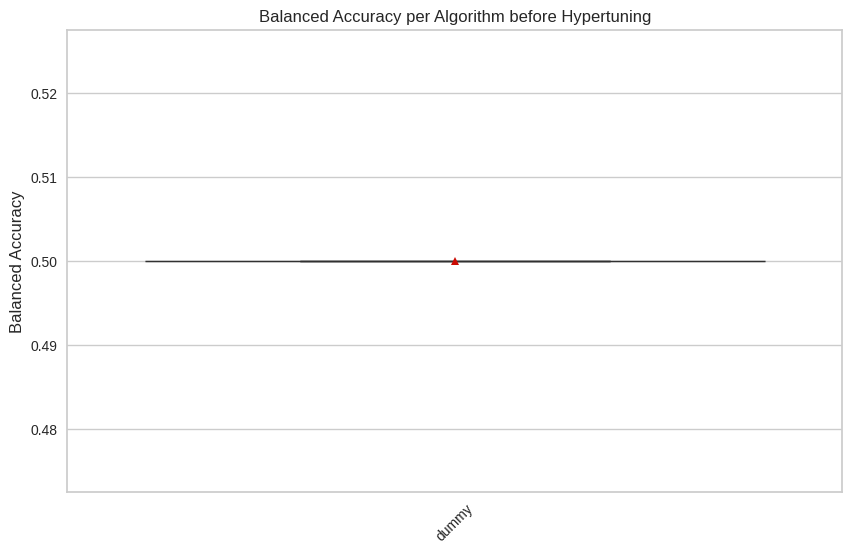

In [ ]:
score_metric = scoring
dfunc.plot_model_score([collect_cv_results_dummy],
                 score = score_metric, classifiers_names = dummy_name,
                 colors = ['skyblue'], tilt_x = True,
                 title = score_metric.replace('_',' ').title()+
                        ' per Algorithm before Hypertuning')  ;

#### Confusion Matrices before Hypertune

''

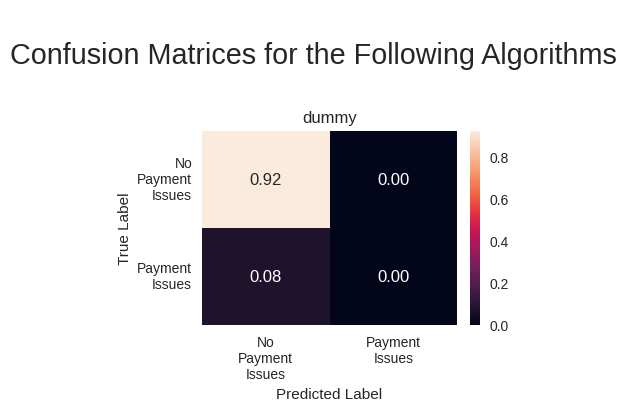

In [ ]:
%reload_ext autoreload

dfunc.plot_confusion_matrices(model_prob_dummy,y_test,
                              names = dummy_name,
                              n_cols = 3, normalize = 'all', labels = labels,
                              title = 'for the Following Algorithms')
;

### Scores per Basic Model BEFORE Hyperparameter Tuning

First, we do a crossvalidation on support vector machines, logistic regression, k-nearest neighbors, decision tree, and random forest, LightGBM, and XGBoost algorithms with their default parameters to see where we stand.

In [ ]:
%%time
%reload_ext autoreload

estimators_basic = []
for clas in classifiers:
    estimators_basic.append(classifier_map[clas])

models_basic=[]
for estimator in estimators_basic:
    pipe_steps = pipe_prep_steps.copy()
    pipe_steps.append(('classifier' , estimator))
    models_basic.append(Pipeline(pipe_steps))

model_cv_results_before = dfunc.model_scores(X_train,y_train,X_test,
                                      models = models_basic,
                                      model_names = classifiers,
                                      cv = cvRSK)

(model_performance_before,
 collect_cv_results_before,
 model_prob_before) = model_cv_results_before

Die letzten 5000 Zeilen der Streamingausgabe wurden abgeschnitten.
[3]	validation_0-logloss:0.22380
[4]	validation_0-logloss:0.22359
[5]	validation_0-logloss:0.23008
[6]	validation_0-logloss:0.22814
[7]	validation_0-logloss:0.22635
[8]	validation_0-logloss:0.22977
[9]	validation_0-logloss:0.23321
[10]	validation_0-logloss:0.23592
[11]	validation_0-logloss:0.23492
[12]	validation_0-logloss:0.23538
[13]	validation_0-logloss:0.23567
[14]	validation_0-logloss:0.23601
[15]	validation_0-logloss:0.23571
[16]	validation_0-logloss:0.23744
[17]	validation_0-logloss:0.23906
[18]	validation_0-logloss:0.24077
[19]	validation_0-logloss:0.23971
[20]	validation_0-logloss:0.24219
[21]	validation_0-logloss:0.24123
[22]	validation_0-logloss:0.24368
[23]	validation_0-logloss:0.24838
[24]	validation_0-logloss:0.25344
[25]	validation_0-logloss:0.25515
[26]	validation_0-logloss:0.25636
[27]	validation_0-logloss:0.25970
[28]	validation_0-logloss:0.26103
[29]	validation_0-logloss:0.26531
[30]	validation_0-logl

In [ ]:
model_performance_before.round(3)

,accuracy mean,accuracy std,balanced accuracy mean,balanced accuracy std,f1 mean,f1 std,f1 micro mean,f1 micro std,f1 macro mean,f1 macro std,f1 weighted mean,f1 weighted std,precision mean,precision std,precision micro mean,precision micro std,precision macro mean,precision macro std,precision weighted mean,precision weighted std,average precision mean,average precision std,recall mean,recall std,recall micro mean,recall micro std,recall macro mean,recall macro std,recall weighted mean,recall weighted std,roc auc mean,roc auc std,roc auc ovr mean,roc auc ovr std,roc auc ovo mean,roc auc ovo std,roc auc ovr weighted mean,roc auc ovr weighted std,roc auc ovo weighted mean,roc auc ovo weighted std
Logistic Regression,0.677,0.024,0.657,0.038,0.228,0.024,0.677,0.024,0.512,0.017,0.752,0.017,0.139,0.015,0.677,0.024,0.549,0.011,0.896,0.009,0.201,0.047,0.633,0.084,0.677,0.024,0.657,0.038,0.677,0.024,0.715,0.041,0.715,0.041,0.715,0.041,0.715,0.041,0.715,0.041
KNN,0.917,0.005,0.507,0.013,0.042,0.043,0.917,0.005,0.499,0.022,0.887,0.005,0.160,0.159,0.917,0.005,0.543,0.080,0.868,0.014,0.114,0.020,0.025,0.026,0.917,0.005,0.507,0.013,0.917,0.005,0.608,0.046,0.608,0.046,0.608,0.046,0.608,0.046,0.608,0.046
Decision Tree,0.871,0.014,0.538,0.037,0.144,0.068,0.871,0.014,0.537,0.036,0.871,0.011,0.145,0.068,0.871,0.014,0.538,0.037,0.871,0.010,0.090,0.019,0.146,0.072,0.871,0.014,0.538,0.037,0.871,0.014,0.538,0.037,0.538,0.037,0.538,0.037,0.538,0.037,0.538,0.037
LightGBM,0.901,0.012,0.554,0.031,0.180,0.073,0.901,0.012,0.564,0.038,0.889,0.010,0.248,0.105,0.901,0.012,0.590,0.054,0.881,0.012,0.201,0.048,0.146,0.063,0.901,0.012,0.554,0.031,0.901,0.012,0.739,0.037,0.739,0.037,0.739,0.037,0.739,0.037,0.739,0.037
XGBoost,0.919,0.005,0.512,0.017,0.054,0.056,0.919,0.005,0.506,0.029,0.889,0.006,0.219,0.219,0.919,0.005,0.573,0.111,0.873,0.018,0.189,0.040,0.032,0.034,0.919,0.005,0.512,0.017,0.919,0.005,0.727,0.036,0.727,0.036,0.727,0.036,0.727,0.036,0.727,0.036


Reminder:
* Precision = TP / (TP + FP)
* Recall = TP / (TP + FN)

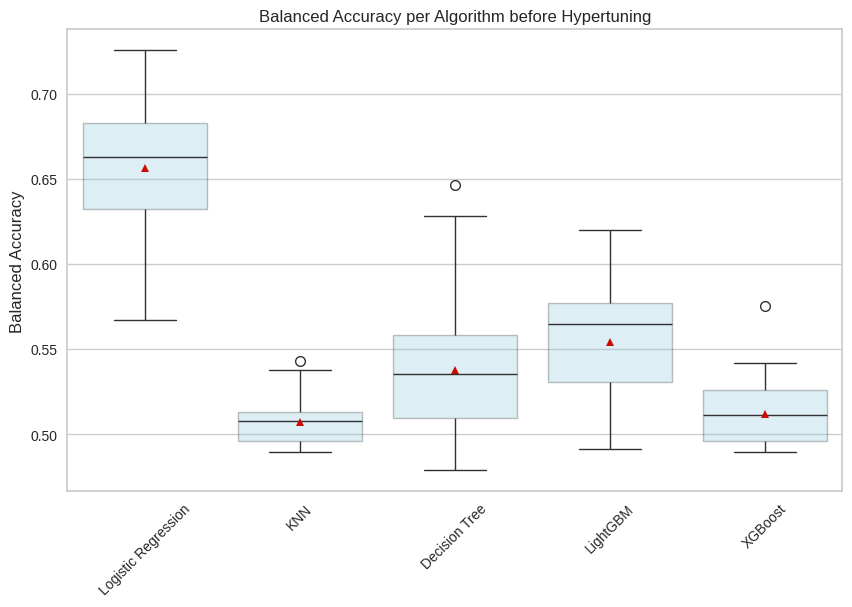

In [ ]:
score_metric = scoring
dfunc.plot_model_score([collect_cv_results_before],
                 score = score_metric, classifiers_names = classifiers,
                 colors = ['skyblue'], tilt_x = True,
                 title = score_metric.replace('_',' ').title()+
                        ' per Algorithm before Hypertuning')  ;

#### Confusion Matrices before Hypertune

''

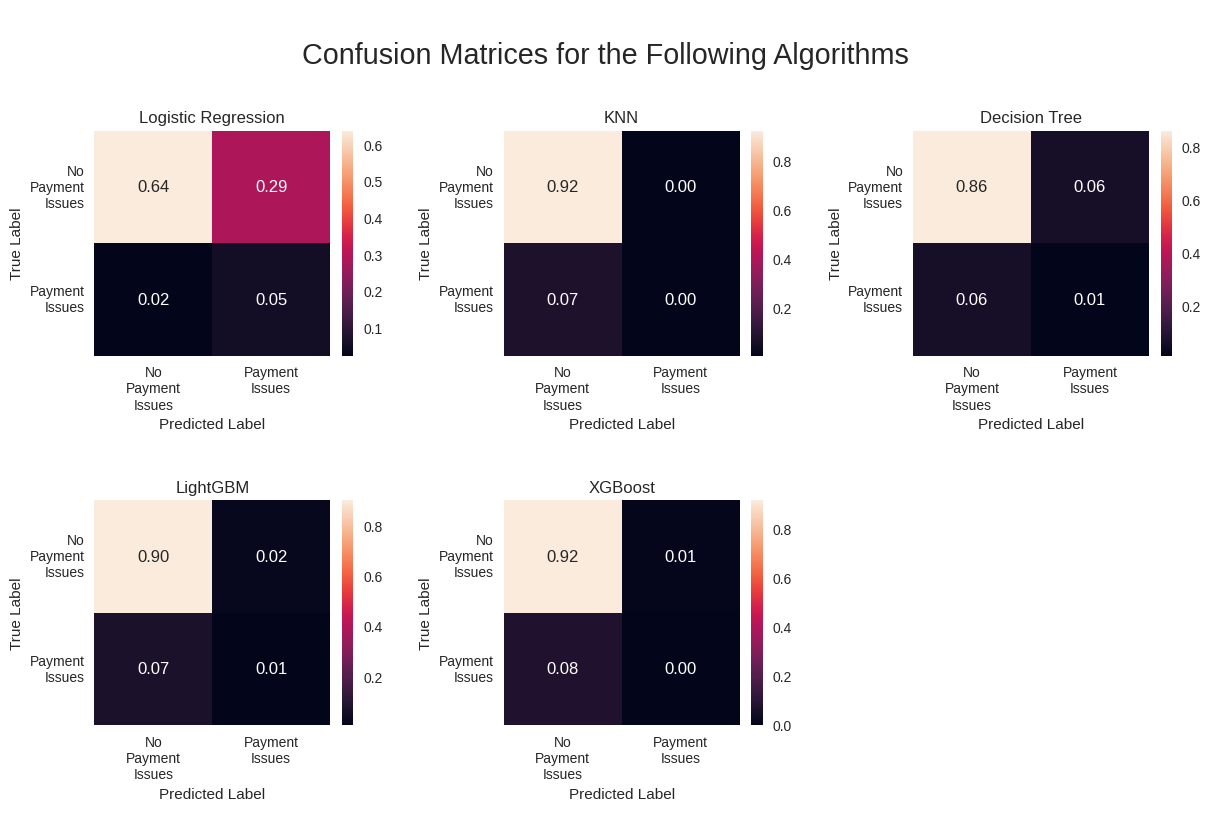

In [ ]:
%reload_ext autoreload

dfunc.plot_confusion_matrices(model_prob_before,y_test,
                              names = classifiers,
                              n_cols = 3, normalize = 'all', labels = labels,
                              title = 'for the Following Algorithms')
;

## Hyperparameter Tuning with BayesSearchCV

In [ ]:
classifiers_h = classifiers

In a previous project, I have made the function 'hyper_search' to loop over the given estimators and several (grid-)search-varieties ('Grid', 'HalvingGrid', 'Random', 'HalvingRandom').
In the following, I will focus on RandomizedSearchCV, which performed best in the previous projects.

The dummy estimator in the pipeline will be replaced by the classifiers in the hyperparameter dictionaries

In [ ]:
pipe_steps = pipe_prep_steps.copy()
pipe_steps.append(('classifier' , RandomForestClassifier()))

pipe = Pipeline(pipe_steps, memory=memory)   # cache pipeline results except from last step



[('preprocessor', preprocessor_scaled)]
X_transformer_steps_tree = [('preprocessor', preprocessor_tree)]

In the following, I create the parameter distribution for Randomized SearchCV per classifier. Since XGBoost and LightGBM are fast, I let them test more parameters.

In [ ]:
%reload_ext autoreload

# Create param distribution (BayesSearchCV) per classifier

hyper_bayes_XGB = {'preprocessor': Categorical([preprocessor_tree]),
          'classifier' : Categorical([XGBClas]),
          "classifier__n_estimators": Integer(50, 1000),
          "classifier__max_depth": Integer(1, 10),
          "classifier__scale_pos_weight": Real(1, 30),
          "classifier__learning_rate": Real(0.05, 0.2),
          'classifier__early_stopping_rounds': Integer(5, 10),
          "classifier__min_child_weight": Integer(1, 12),       # min. number of obs. (hessians) in a node to make split
          "classifier__gamma": Real(0, 1),                   # L0 regularization - dep. on number of leaves
          "classifier__reg_alpha": Real(0, 1),               # L1 regularization
          "classifier__reg_lambda": Real(0, 1),              # L2 regularization
          "classifier__subsample": Real(0.1, 1),
          "classifier__colsample_bytree": Real(0.1, 1),

      }


hyper_bayes_LightGBM = {'preprocessor': Categorical([preprocessor_tree]),
        'classifier' : Categorical([LGBMClas]),
        "classifier__n_estimators": Integer(50, 1000),
        "classifier__max_depth": Integer(1, 12),
        "classifier__boosting_type": Categorical(["gbdt"]),
        "classifier__learning_rate": Real(0.05, 0.2),
        "classifier__lambda_l1": Real(1e-8, 10.0, prior='log-uniform'),
        "classifier__lambda_l2": Real(1e-8, 10.0, prior='log-uniform'),
        "classifier__num_leaves": Integer(2, 256),
        'classifier__early_stopping_round': Integer(1, 10),
        "classifier__feature_fraction": Real(0.4, 1.0),
        "classifier__bagging_fraction": Real(0.4, 1.0),
        "classifier__bagging_freq": Integer(1, 7),
        "classifier__min_child_samples": Integer(5, 100),
        }

hyper_bayes_LinSVC = {
     'classifier' : Categorical([LinSVC_hypersearch]),
     'classifier__C' : Real(0.01, 1e3, prior='log-uniform')}

hyper_bayes_rbfSVC = {
     'classifier' : Categorical([rbfSVC_hypersearch]),
     'classifier__kernel' : Categorical(['rbf']),
     'classifier__C' : Real(0.01, 1e3, prior='log-uniform'),
     'classifier__gamma': Real(0.01, 1e3, prior='log-uniform')}

hyper_bayes_LogReg = {'classifier' : Categorical([LogReg]),
     'classifier__C' : Real(0.01, 1e3, prior='log-uniform')}

hyper_bayes_KNN = {'classifier' : Categorical([KNNClas]),
             'classifier__n_neighbors' : Integer(1, 21),
             'classifier__weights' : Categorical(['uniform','distance']),
             'classifier__metric' : Categorical(['minkowski','euclidean','manhattan'])}

#https://towardsdatascience.com/how-to-tune-a-decision-tree-f03721801680
hyper_bayes_DTC = {'preprocessor': Categorical([preprocessor_tree]),
     'classifier' : Categorical([DTClas]),
     'classifier__min_samples_split' : Integer(10, 41),
     'classifier__min_samples_leaf' : Integer(1, 21)}

hyper_bayes_RFC = {'preprocessor': Categorical([preprocessor_tree]),
     'classifier' : Categorical([RFClas]),
     'classifier__n_estimators' : Integer(10, 1000),
     #'classifier__max_features': Categorical(['sqrt', 'log2', None]),
     #'classifier__max_depth': Integer(1, 10),
     #'classifier__max_leaf_nodes': Integer(1, 10)
                    }


# Classifiers and their corresponding hyperparameter setup
param_bayes_map = {'Linear Svm': hyper_bayes_LinSVC,
                  'Radial Svm': hyper_bayes_rbfSVC,
                  'Logistic Regression': hyper_bayes_LogReg,
                  'KNN': hyper_bayes_KNN,
                  'Decision Tree': hyper_bayes_DTC,
                  'Random Forest': hyper_bayes_RFC,
                  'LightGBM': hyper_bayes_LightGBM,
                  'XGBoost': hyper_bayes_XGB
}

# hyperparameter setups used in this run:
param_distro_bayes = []
for clas in classifiers_h:
    param_distro_bayes.append(param_bayes_map[clas])

### on Balanced Accuracy

In [ ]:
ht_scoring = 'balanced_accuracy'

#### Hyperparameter Tuning

In [ ]:
%%time
%reload_ext autoreload

start = 0
stop = 4

hyper_params = dfunc.hyper_search(pipe,  X_train, y_train,
                            param_bayes = param_distro_bayes, #[start:stop],
                            classifier_names = classifiers,#[start:stop],
                            cv = cvSK, niter = 20,
                            searches = ['Bayes'],
                            scoring = ht_scoring,
                            random_state = 3,
                            verbose=0)

Executing Logistic Regression
for search method: Bayes
best score: 0.656
best parameters: OrderedDict([('classifier', LogisticRegression(class_weight='balanced', n_jobs=-1, random_state=1)), ('classifier__C', 0.02650396190699432)])
 
Executing KNN
for search method: Bayes
best score: 0.53
best parameters: OrderedDict([('classifier', KNeighborsClassifier(n_jobs=-1)), ('classifier__metric', 'minkowski'), ('classifier__n_neighbors', 2), ('classifier__weights', 'distance')])
 
Executing Decision Tree
for search method: Bayes
best score: 0.6
best parameters: OrderedDict([('classifier', DecisionTreeClassifier(class_weight='balanced', random_state=1)), ('classifier__min_samples_leaf', 18), ('classifier__min_samples_split', 41), ('preprocessor', ColumnTransformer(remainder='passthrough', sparse_threshold=0,
                  transformers=[('num',
                                 Pipeline(steps=[('imputer',
                                                  KNNImputer(n_neighbors=3))]),
        

In [ ]:
hyper_params

,classifier,search method,best score,time[s],best params
0,Logistic Regression,Bayes,0.656,42.5,"{'classifier': LogisticRegression(class_weight='balanced', n_jobs=-1, random_state=1), 'classifier__C': 0.02650396190699432}"
1,KNN,Bayes,0.530,44.7,"{'classifier': KNeighborsClassifier(n_jobs=-1), 'classifier__metric': 'minkowski', 'classifier__n_neighbors': 2, 'classifier__weights': 'distance'}"
2,Decision Tree,Bayes,0.600,35.4,"{'classifier': DecisionTreeClassifier(class_weight='balanced', random_state=1), 'classifier__min_samples_leaf': 18, 'classifier__min_samples_split': 41, 'preprocessor': ColumnTransformer(remainder='passthrough', sparse_threshold=0, transformers=[('num', Pipeline(steps=[('imputer', KNNImputer(n_neighbors=3))]), ['LIVINGAREA_MODE', 'YEARS_BEGINEXPLUATATION_AVG', 'NONLIVINGAPARTMENTS_AVG', 'ENTRANCES_AVG', 'EXT_SOURCE_3', 'EXT_SOURCE_2', 'EXT_SOURCE_1', 'APARTMENTS_MODE', 'BASEMENTAREA_MODE', 'YEARS_BUILD_MODE', 'LANDAREA_MODE', 'HO... 'LIVINGAPARTMENTS_MODE', 'FLOORSMIN_AVG', 'NONLIVINGAREA_MODE', 'DAYS_LAST_PHONE_CHANGE', 'COMMONAREA_MEDI', 'EXT_SUM2', 'dti', 'OWN_CAR_AGE', 'EXT_RATIO', 'DAYS_ID_PUBLISH', 'DAYS_REGISTRATION', 'DAYS_EMPLOYED', 'AMT_ANNUITY_CREDIT_ratio', 'DAYS_BIRTH', 'building_avg', 'REGION_POPULATION_RELATIVE', 'AMT_INCOME_TOTAL']), ('cat', Pipeline(steps=[('encoder', OneHotEncoder(handle_unknown='ignore'))]), [])])}"
3,LightGBM,Bayes,0.674,52.9,"{'classifier': LGBMClassifierWithEarlyStop(boosting_type='gbdt', class_weight='balanced', colsample_bytree=1.0, early_stopping_round=10, force_row_wise=True, importance_type='split', learning_rate=0.1, max_depth=-1, metric='binary_logloss', min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0, n_estimators=100, n_jobs=None, num_leaves=31, objective='binary', random_state=1, reg_alpha=0.0, reg_lambda=0.0, subsample=1.0, subsample_for_bin=200000, subsample_freq=0, verbosity=-100), 'classifier__bagging_fraction': 0.5020445730612196, 'classifier__bagging_freq': 3, 'classifier__boosting_type': 'gbdt', 'classifier__early_stopping_round': 2, 'classifier__feature_fraction': 0.8723441532811419, 'classifier__lambda_l1': 6.920982804410259, 'classifier__lambda_l2': 0.0009453670928343726, 'classifier__learning_rate': 0.16714220492715923, 'classifier__max_depth': 2, 'classifier__min_child_samples': 78, 'classifier__n_estimators': 241, 'classifier__num_leaves': 14, 'preprocessor': ColumnTransformer(remainder='passthrough', sparse_threshold=0, transformers=[('num', Pipeline(steps=[('imputer', KNNImputer(n_neighbors=3))]), ['LIVINGAREA_MODE', 'YEARS_BEGINEXPLUATATION_AVG', 'NONLIVINGAPARTMENTS_AVG', 'ENTRANCES_AVG', 'EXT_SOURCE_3', 'EXT_SOURCE_2', 'EXT_SOURCE_1', 'APARTMENTS_MODE', 'BASEMENTAREA_MODE', 'YEARS_BUILD_MODE', 'LANDAREA_MODE', 'HO... 'LIVINGAPARTMENTS_MODE', 'FLOORSMIN_AVG', 'NONLIVINGAREA_MODE', 'DAYS_LAST_PHONE_CHANGE', 'COMMONAREA_MEDI', 'EXT_SUM2', 'dti', 'OWN_CAR_AGE', 'EXT_RATIO', 'DAYS_ID_PUBLISH', 'DAYS_REGISTRATION', 'DAYS_EMPLOYED', 'AMT_ANNUITY_CREDIT_ratio', 'DAYS_BIRTH', 'building_avg', 'REGION_POPULATION_RELATIVE', 'AMT_INCOME_TOTAL']), ('cat', Pipeline(steps=[('encoder', OneHotEncoder(handle_unknown='ignore'))]), [])])}"
4,XGBoost,Bayes,0.676,61.3,"{'classifier': XGBoostClassifierWithEarlyStop(base_score=None, booster=None, callbacks=None, colsample_bylevel=None, colsample_bynode=None, colsample_bytree=None, device=None, early_stopping_rounds=None, enable_categorical=False, eval_metric=None, feature_types=None, gamma=None, grow_policy=None, importance_type=None, interaction_constraints=None, learning_rate=None, max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None, max_delta_step=None, max_depth=None, max_leaves=None, min_child_weight=None, missing=nan, monotone_constraints=None, multi_strategy=None, n_estimators=None, n_jobs=None, num_parallel_tree=None, objective='binary:logistic', ...), 'classifier__colsample_bytree': 0.2855964688820752, 'classifier__early_stopping_rounds': 5, 'classifier__gamma': 0.515971188017198

Extract the best tuned hyperparameters per classifier:

In [ ]:
param_classifiers={}


for classifier in classifiers_h:
    param_classifier = hyper_params.loc[(hyper_params['classifier']==classifier)]
    param_classifier = param_classifier.loc[param_classifier['best score']==param_classifier['best score'].max()]['best params'].values[0]
    # replace the 'classifier__' in the keys --> can insert best params directly into untuned classifiers
    if 'preprocessor' in param_classifier.keys():
        param_classifier.pop('preprocessor')
    if 'classifier' in param_classifier.keys():
        param_classifier.pop('classifier')
    new_keys = [key.replace('classifier__','') for key in param_classifier.keys()]
    param_classifier = dict(zip(new_keys, list(param_classifier.values())))
    print(param_classifier)
    param_classifiers[classifier] = param_classifier

{'C': 0.02650396190699432}
{'metric': 'minkowski', 'n_neighbors': 2, 'weights': 'distance'}
{'min_samples_leaf': 18, 'min_samples_split': 41}
{'bagging_fraction': 0.5020445730612196, 'bagging_freq': 3, 'boosting_type': 'gbdt', 'early_stopping_round': 2, 'feature_fraction': 0.8723441532811419, 'lambda_l1': 6.920982804410259, 'lambda_l2': 0.0009453670928343726, 'learning_rate': 0.16714220492715923, 'max_depth': 2, 'min_child_samples': 78, 'n_estimators': 241, 'num_leaves': 14}
{'colsample_bytree': 0.2855964688820752, 'early_stopping_rounds': 5, 'gamma': 0.515971188017198, 'learning_rate': 0.05066748705958484, 'max_depth': 4, 'min_child_weight': 8, 'n_estimators': 124, 'reg_alpha': 0.1068382348828846, 'reg_lambda': 0.5423336118409082, 'scale_pos_weight': 29.39412438747881, 'subsample': 0.4721048291741773}


##### Update the base classifiers with the hypertuned parameters:

In [ ]:
%%capture

LinSVC_h = copy.deepcopy(LinSVC_hypersearch)
if 'Linear Svm' in param_classifiers.keys():
    # probability=True in SVMs needed for later scoring:
    LinSVC_h.set_params(**param_classifiers['Linear Svm'], probability=True)

rbfSVC_h = copy.deepcopy(rbfSVC_hypersearch)
if 'Radial Svm' in param_classifiers.keys():
    rbfSVC_h.set_params(**param_classifiers['Radial Svm'], probability=True)

LogReg_h = copy.deepcopy(LogReg)
if 'Logistic Regression' in param_classifiers.keys():
    LogReg_h.set_params(**param_classifiers['Logistic Regression'])

KNNClas_h = copy.deepcopy(KNNClas)
if 'KNN' in param_classifiers.keys():
    KNNClas_h.set_params(**param_classifiers['KNN'])

DTClas_h = copy.deepcopy(DTClas)
if 'Decision Tree' in param_classifiers.keys():
    DTClas_h.set_params(**param_classifiers['Decision Tree'])

RFClas_h = copy.deepcopy(RFClas)
if 'Random Forest' in param_classifiers.keys():
    RFClas_h.set_params(**param_classifiers['Random Forest'])

LGBMClas_h = copy.deepcopy(LGBMClas)
if 'LightGBM' in param_classifiers.keys():
    LGBMClas_h.set_params(**param_classifiers['LightGBM'])

XGBClas_h = copy.deepcopy(XGBClas)
if 'XGBoost' in param_classifiers.keys():
    XGBoost_param_fit={}
    # cross_val_score cannot deal with 'early_stopping_rounds'
    # ---> put it into fit_params for the fit-function:
    if 'early_stopping_rounds' in param_classifiers['XGBoost']:
        XGBoost_param_fit['classifier__early_stopping_rounds'] = param_classifiers['XGBoost']['early_stopping_rounds']
        param_classifiers['XGBoost'].pop('early_stopping_rounds')
    XGBClas_h.set_params(**param_classifiers['XGBoost'])



# hypertuned estimators and their names
classifier_map_h = {'Linear Svm': LinSVC_h,
                  'Radial Svm': rbfSVC_h,
                  'Logistic Regression': LogReg_h,
                  'KNN': KNNClas_h,
                  'Decision Tree': DTClas_h,
                  'Random Forest': RFClas_h,
                  'LightGBM': LGBMClas_h,
                  'XGBoost': XGBClas_h
}

#### Scores per Basic Model AFTER Hyperparameter Tuning

Let's redo the crossvalidation on the algorithms with their now tuned parameters.

In [ ]:
#classifiers_h =[#'KNN',
# #'Decision Tree',
# 'LightGBM']

In [ ]:
#estimators_hyped = []
#for clas in classifiers_h:
#    estimators_hyped.append(classifier_map_h[clas])


#for estimator in estimators_hyped:

models_hyped=[]
fit_params_hyped=[]

for clas in classifiers_h:
    estimator = classifier_map_h[clas]
    if clas in ['Linear Svm','Radial Svm', 'Logistic Regression', 'KNN']:
        pipe_steps = pipe_prep_steps.copy()
    else:
        pipe_steps = pipe_prep_steps_tree.copy()
    pipe_steps.append(('classifier' , estimator))
    models_hyped.append(Pipeline(pipe_steps))

    if estimator == XGBClas_h:
        fit_params_hyped.append(XGBoost_param_fit)
    else:
        fit_params_hyped.append(None)

In [ ]:
%%time
%reload_ext autoreload



model_cv_results_after = dfunc.model_scores(X_train,y_train,X_test,
                                      models = models_hyped,
                                      model_names = classifiers_h,
                                      fit_params = fit_params_hyped,
                                      cv = cvRSK)

(model_performance_after,
 collect_cv_results_after,
 model_prob_after) = model_cv_results_after

Die letzten 5000 Zeilen der Streamingausgabe wurden abgeschnitten.
[17]	validation_0-logloss:0.79099
[18]	validation_0-logloss:0.77514
[19]	validation_0-logloss:0.76500
[20]	validation_0-logloss:0.75402
[21]	validation_0-logloss:0.74085
[22]	validation_0-logloss:0.73406
[23]	validation_0-logloss:0.73484
[24]	validation_0-logloss:0.72891
[25]	validation_0-logloss:0.72824
[26]	validation_0-logloss:0.71715
[27]	validation_0-logloss:0.71096
[28]	validation_0-logloss:0.70942
[29]	validation_0-logloss:0.69810
[30]	validation_0-logloss:0.68538
[31]	validation_0-logloss:0.68013
[32]	validation_0-logloss:0.67957
[33]	validation_0-logloss:0.67515
[34]	validation_0-logloss:0.66906
[35]	validation_0-logloss:0.66577
[36]	validation_0-logloss:0.65848
[37]	validation_0-logloss:0.64721
[38]	validation_0-logloss:0.64575
[39]	validation_0-logloss:0.64482
[40]	validation_0-logloss:0.64358
[41]	validation_0-logloss:0.63968
[42]	validation_0-logloss:0.63964
[43]	validation_0-logloss:0.63364
[44]	validation

In [ ]:
model_performance_after.round(3)

,accuracy mean,accuracy std,balanced accuracy mean,balanced accuracy std,f1 mean,f1 std,f1 micro mean,f1 micro std,f1 macro mean,f1 macro std,f1 weighted mean,f1 weighted std,precision mean,precision std,precision micro mean,precision micro std,precision macro mean,precision macro std,precision weighted mean,precision weighted std,average precision mean,average precision std,recall mean,recall std,recall micro mean,recall micro std,recall macro mean,recall macro std,recall weighted mean,recall weighted std,roc auc mean,roc auc std,roc auc ovr mean,roc auc ovr std,roc auc ovo mean,roc auc ovo std,roc auc ovr weighted mean,roc auc ovr weighted std,roc auc ovo weighted mean,roc auc ovo weighted std
Logistic Regression,0.681,0.026,0.665,0.039,0.235,0.026,0.681,0.026,0.517,0.019,0.756,0.019,0.144,0.016,0.681,0.026,0.552,0.012,0.898,0.009,0.203,0.047,0.646,0.084,0.681,0.026,0.665,0.039,0.681,0.026,0.723,0.040,0.723,0.040,0.723,0.040,0.723,0.040,0.723,0.040
KNN,0.868,0.012,0.536,0.028,0.143,0.052,0.868,0.012,0.536,0.028,0.869,0.009,0.141,0.053,0.868,0.012,0.536,0.029,0.870,0.008,0.111,0.024,0.146,0.053,0.868,0.012,0.536,0.028,0.868,0.012,0.565,0.040,0.565,0.040,0.565,0.040,0.565,0.040,0.565,0.040
Decision Tree,0.721,0.032,0.591,0.055,0.191,0.044,0.721,0.032,0.511,0.028,0.783,0.022,0.123,0.028,0.721,0.032,0.532,0.019,0.880,0.012,0.126,0.035,0.438,0.111,0.721,0.032,0.591,0.055,0.721,0.032,0.613,0.061,0.613,0.061,0.613,0.061,0.613,0.061,0.613,0.061
LightGBM,0.689,0.045,0.645,0.041,0.225,0.031,0.689,0.045,0.515,0.028,0.761,0.033,0.140,0.021,0.689,0.045,0.547,0.014,0.893,0.009,0.173,0.038,0.594,0.090,0.689,0.045,0.645,0.041,0.689,0.045,0.715,0.039,0.715,0.039,0.715,0.039,0.715,0.039,0.715,0.039
XGBoost,0.735,0.049,0.668,0.047,0.252,0.037,0.735,0.049,0.545,0.030,0.793,0.035,0.162,0.025,0.735,0.049,0.559,0.016,0.897,0.010,0.205,0.047,0.589,0.116,0.735,0.049,0.668,0.047,0.735,0.049,0.746,0.040,0.746,0.040,0.746,0.040,0.746,0.040,0.746,0.040


In [ ]:
%reload_ext autoreload

model_performance_after_test = dfunc.get_test_scores_binary(y_test, model_prob_after, model_names = classifiers_h)
model_performance_after_test.round(3)

,balanced accuracy,f1,precision,recall,roc auc
Logistic Regression,0.694,0.253,0.155,0.70,0.781
KNN,0.586,0.227,0.208,0.25,0.634
Decision Tree,0.685,0.271,0.175,0.60,0.652
LightGBM,0.616,0.209,0.132,0.50,0.718
XGBoost,0.613,0.227,0.158,0.40,0.726


##### Score Plots

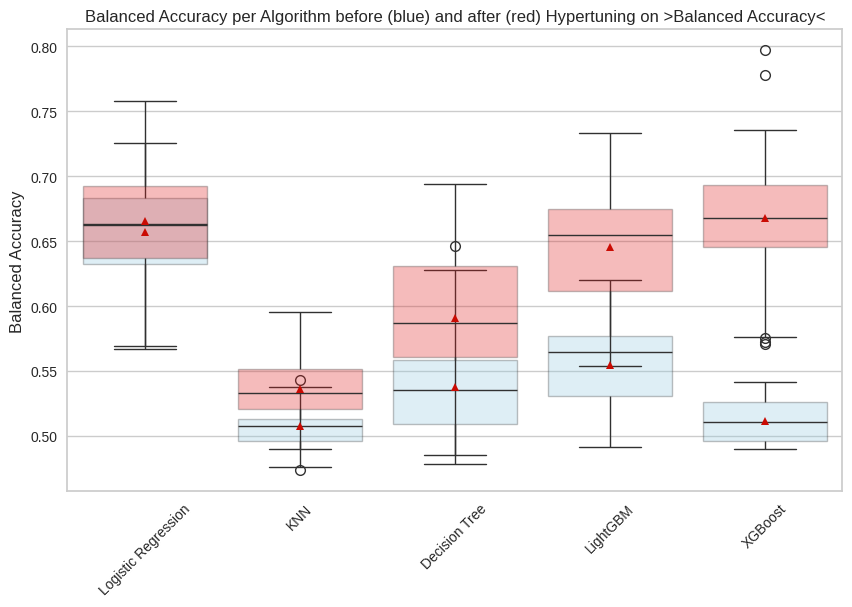

In [ ]:
score_metric = scoring
dfunc.plot_model_score([collect_cv_results_before, collect_cv_results_after],
                 score = score_metric, classifiers_names = classifiers_h,
                 colors = ['skyblue', 'red'], tilt_x = True,
                 title = score_metric.replace('_',' ').title()+
                        ' per Algorithm before (blue) '+
                        'and after (red) Hypertuning on >'+
                              ht_scoring.replace('_', ' ').title() +
                              '<')  ;

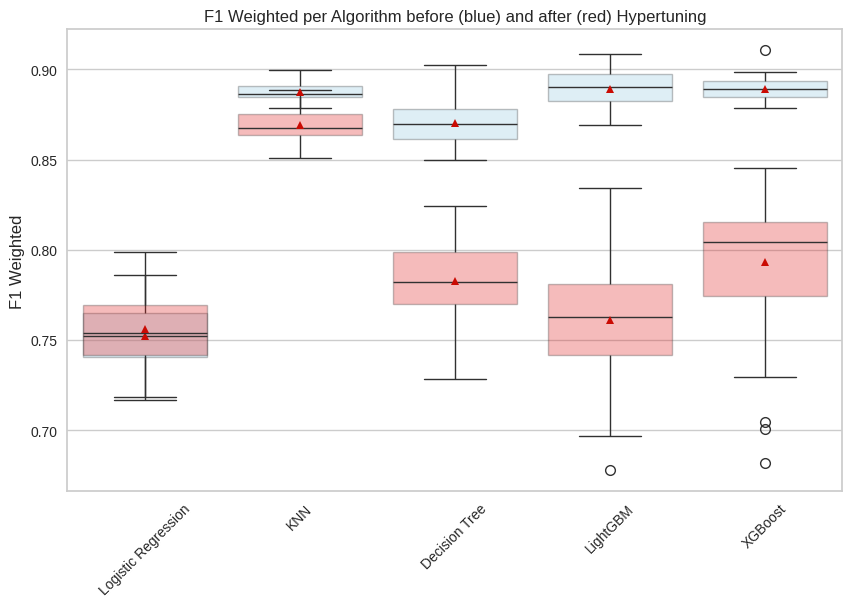

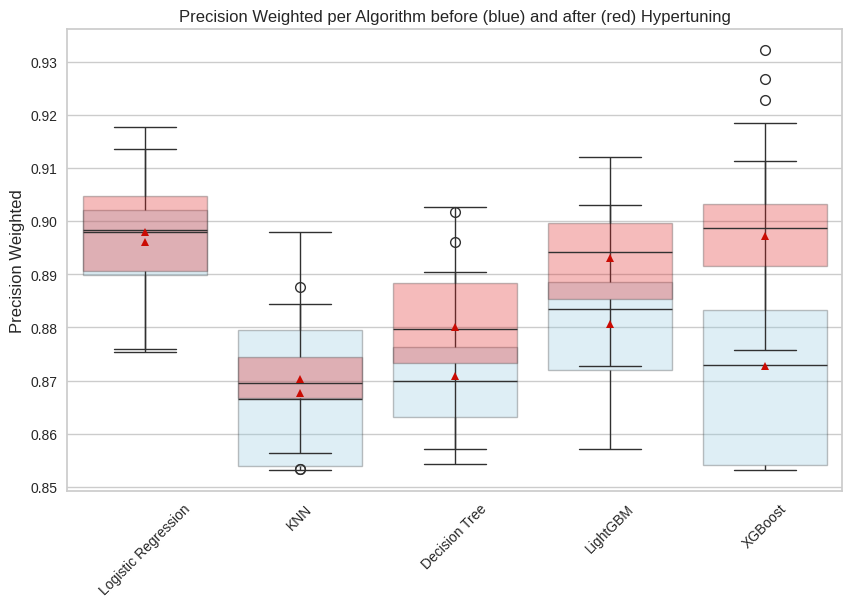

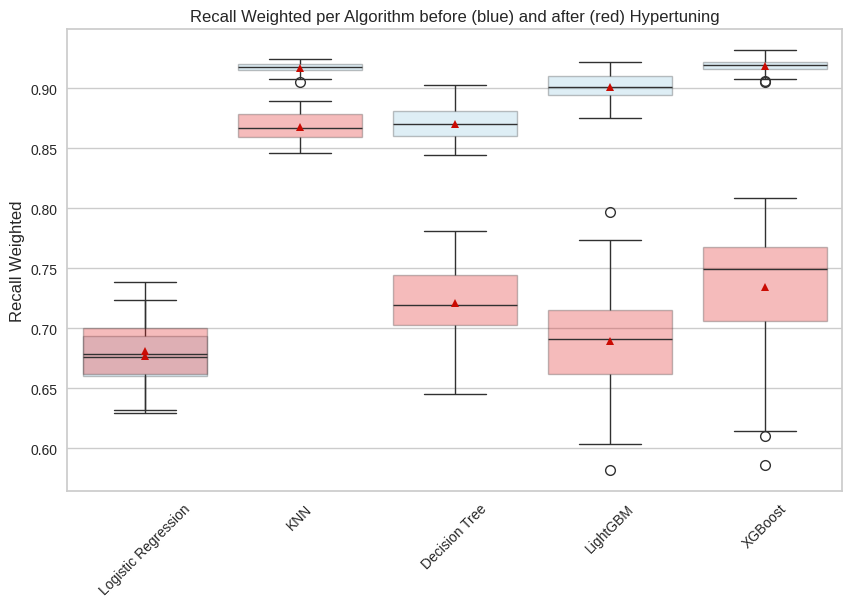

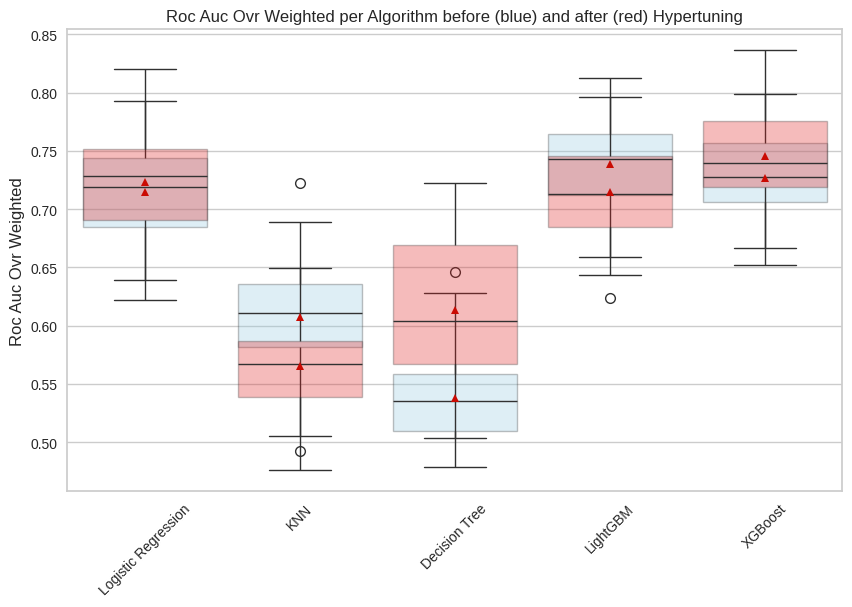

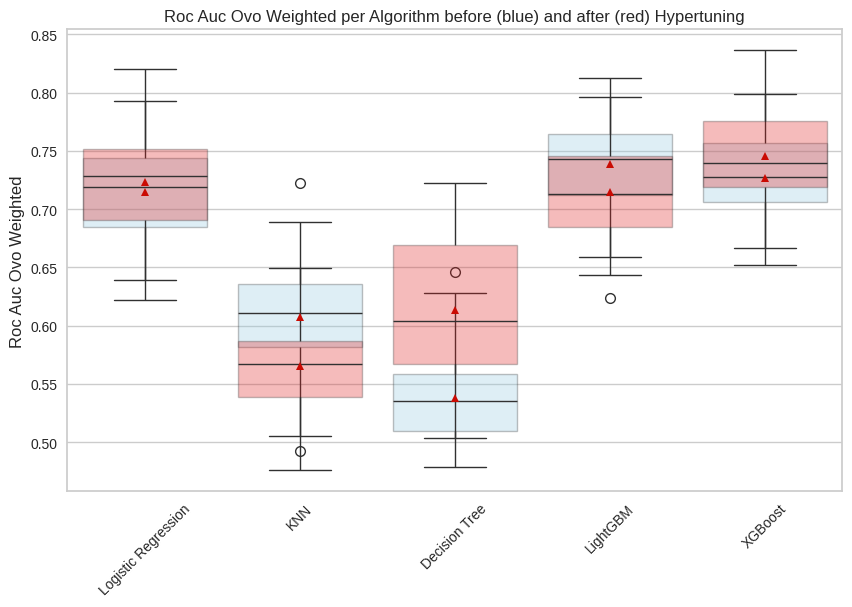

In [ ]:
score_metrics = ['balanced_accuracy', 'f1_weighted', 'precision_weighted', 'recall_weighted',
                 'roc_auc_ovr_weighted', 'roc_auc_ovo_weighted']

for score_metric in score_metrics:
    if score_metric is not scoring:
        dfunc.plot_model_score([collect_cv_results_before, collect_cv_results_after],
                 score = score_metric, classifiers_names = classifiers_h,
                 colors = ['skyblue', 'red'], tilt_x = True,
                 title = score_metric.replace('_',' ').title()+
                        ' per Algorithm before (blue) '+
                        'and after (red) Hypertuning')  ;

In [ ]:
#from sklearn.metrics import classification_report
#y_pred = (model_prob_after[-1][:, 1] > 0.5)#.astype("float")
#print(classification_report(y_test, y_pred))

##### Confusion Matrices after Hypertune

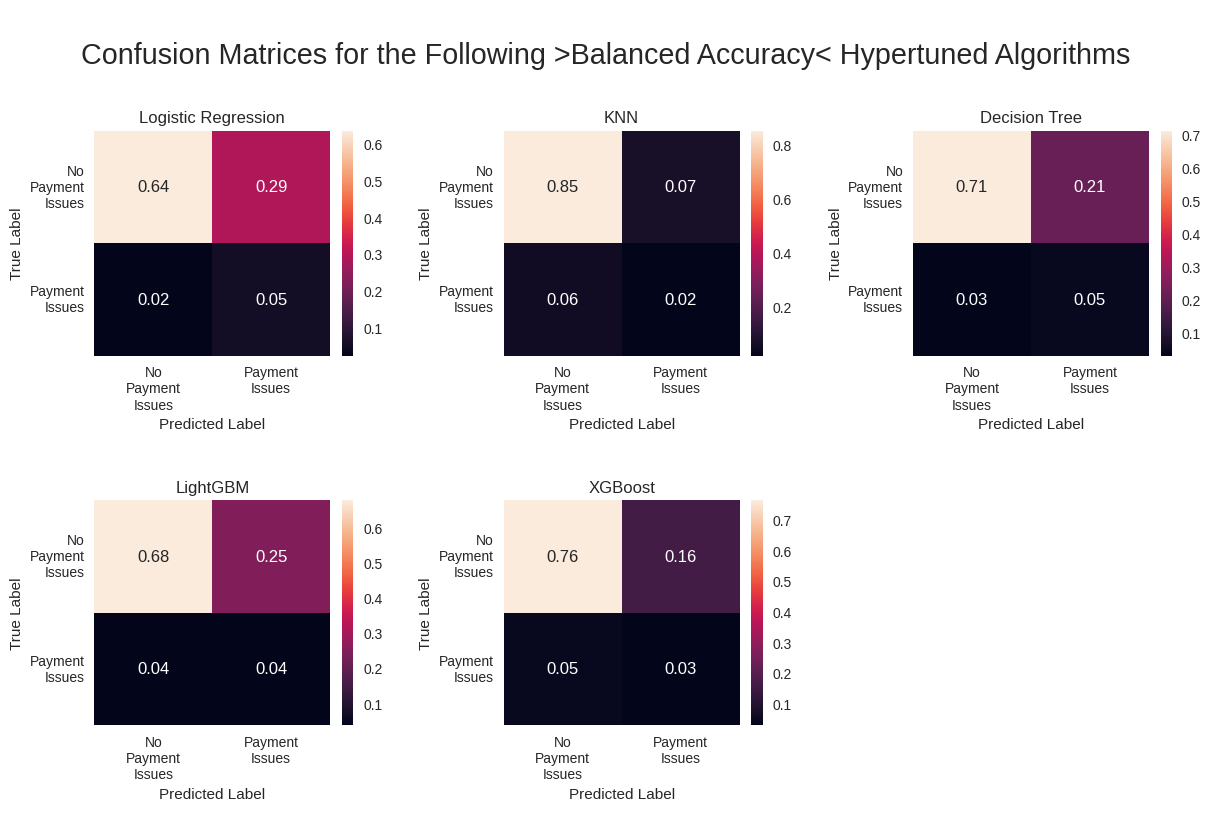

In [ ]:
%reload_ext autoreload


dfunc.plot_confusion_matrices(model_prob_after,y_test,
                              names = classifiers_h,
                              #threshold = 0.4,
                              n_cols = 3, normalize = 'all', labels = labels,
                              title = 'for the Following >'+
                              ht_scoring.replace('_', ' ').title() +
                              '< Hypertuned Algorithms')

## Ensemble

### Voting Classifier

In [ ]:
%%time
%reload_ext autoreload

classifiers_vot = classifiers_h.copy()

to_exclude = ['Linear Svm','Radial Svm',
             #'Logistic Regression',
             'KNN',
             #'Decision Tree',
              'Random Forest',
             #'LightGBM',
              'XGBoost'
              ]
for item in to_exclude:
    if item in classifiers_vot:
        classifiers_vot.remove(item)

estimators_vot = []
for clas in classifiers_vot:
    estimators_vot.append(classifier_map_h[clas])

estimators_list = list(zip(classifiers_vot,estimators_vot))

# Need to remove XGBoost because it needs fit_params for early stopping
# - unclear how to implement this without crashing
if 'XGBoost' in classifiers_vot:
    index = classifiers_vot.index('XGBoost')
    estimators_list.pop(index)

vot_clas = VotingClassifier(estimators = estimators_list,
                            voting='soft')
vot_class_name = 'vot_classifiers'

pipe_steps = pipe_prep_steps.copy()
pipe_steps.append((vot_class_name , vot_clas))

vot_pipe = Pipeline(pipe_steps)

vot_perf, vot_results, vot_prob = dfunc.model_scores(X_train,y_train,X_test,
                                                     models = [vot_pipe],
                                                     model_names = [vot_class_name],
                                                     cv = cvRSK)


Executing vot_classifiers
Done!
CPU times: user 52.4 s, sys: 20.1 s, total: 1min 12s
Wall time: 55.1 s


In [ ]:
vot_perf.round(3)

,accuracy mean,accuracy std,balanced accuracy mean,balanced accuracy std,f1 mean,f1 std,f1 micro mean,f1 micro std,f1 macro mean,f1 macro std,f1 weighted mean,f1 weighted std,precision mean,precision std,precision micro mean,precision micro std,precision macro mean,precision macro std,precision weighted mean,precision weighted std,average precision mean,average precision std,recall mean,recall std,recall micro mean,recall micro std,recall macro mean,recall macro std,recall weighted mean,recall weighted std,roc auc mean,roc auc std,roc auc ovr mean,roc auc ovr std,roc auc ovo mean,roc auc ovo std,roc auc ovr weighted mean,roc auc ovr weighted std,roc auc ovo weighted mean,roc auc ovo weighted std
vot_classifiers,0.745,0.026,0.619,0.053,0.218,0.045,0.745,0.026,0.533,0.028,0.8,0.018,0.142,0.03,0.745,0.026,0.545,0.02,0.886,0.012,0.185,0.051,0.471,0.106,0.745,0.026,0.619,0.053,0.745,0.026,0.717,0.047,0.717,0.047,0.717,0.047,0.717,0.047,0.717,0.047


In [ ]:
%reload_ext autoreload

vot_perf_test = dfunc.get_test_scores_binary(y_test, vot_prob, model_names = ['voting classifier'])
vot_perf_test.round(3)

,balanced accuracy,f1,precision,recall,roc auc
voting classifier,0.675,0.275,0.183,0.55,0.763


In [ ]:
#columns_home = home_folder+'columns/'
#os.mkdir(home_folder+'columns/')
##! mkdir columns_home
#filename = columns_home+ 'vot_class_cols.pickle'
#pickle.dump(vot_perf_test,open(filename, 'wb'))

In [ ]:
#pickle_in = open(filename,"rb")
#vot_perf_test_pickled=pickle.load(pickle_in)
#vot_perf_test_pickled

In [ ]:
#vot_perf.loc[vot_perf.index == 'vot_classifiers']

##### Confusion Matrix

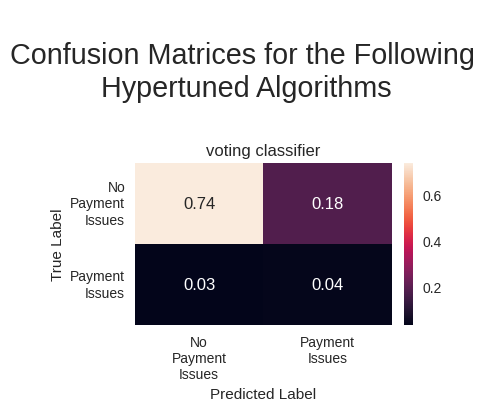

In [ ]:
%reload_ext autoreload

dfunc.plot_confusion_matrices(vot_prob, y_test,
                              names = ['voting classifier'],
                              n_cols = 1, normalize = 'all',
                              threshold = 0.5, labels = labels,
                              title = 'for the Following \nHypertuned Algorithms')

### Bagging Logistic Regression

In [ ]:
%%time
%reload_ext autoreload

# XGBoost issues with fit_params again...

clf_name = 'Logistic Regression'
clf = classifier_map_h[clf_name]

index = classifiers_h.index(clf_name)
fit_params = fit_params_hyped[index]

bag_name = 'bag_'+clf_name.replace(' ', '_')
bag_clas = BaggingClassifier(base_estimator=clf,random_state=0,n_estimators=100)

pipe_steps = pipe_prep_steps.copy()
pipe_steps.append((bag_name , bag_clas))
bag_pipe = Pipeline(pipe_steps)

bag_perf, bag_results, bag_prob = dfunc.model_scores(X_train, y_train, X_test,
                                                     models = [bag_pipe],
                                                     model_names = [bag_name],
                                                     cv = cvRSK)


Executing bag_Logistic_Regression
Done!
CPU times: user 1min 36s, sys: 32.1 s, total: 2min 8s
Wall time: 3min 13s


In [ ]:
bag_perf.round(3)

,accuracy mean,accuracy std,balanced accuracy mean,balanced accuracy std,f1 mean,f1 std,f1 micro mean,f1 micro std,f1 macro mean,f1 macro std,f1 weighted mean,f1 weighted std,precision mean,precision std,precision micro mean,precision micro std,precision macro mean,precision macro std,precision weighted mean,precision weighted std,average precision mean,average precision std,recall mean,recall std,recall micro mean,recall micro std,recall macro mean,recall macro std,recall weighted mean,recall weighted std,roc auc mean,roc auc std,roc auc ovr mean,roc auc ovr std,roc auc ovo mean,roc auc ovo std,roc auc ovr weighted mean,roc auc ovr weighted std,roc auc ovo weighted mean,roc auc ovo weighted std
bag_Logistic_Regression,0.706,0.022,0.664,0.04,0.24,0.028,0.706,0.022,0.529,0.018,0.774,0.016,0.149,0.017,0.706,0.022,0.554,0.013,0.897,0.009,0.203,0.047,0.614,0.087,0.706,0.022,0.664,0.04,0.706,0.022,0.724,0.041,0.724,0.041,0.724,0.041,0.724,0.041,0.724,0.041


In [ ]:
%reload_ext autoreload

bag_perf_test = dfunc.get_test_scores_binary(y_test, bag_prob, model_names = [bag_name])
bag_perf_test.round(3)

,balanced accuracy,f1,precision,recall,roc auc
bag_Logistic_Regression,0.684,0.255,0.159,0.65,0.777


##### Confusion Matrix

CPU times: user 239 ms, sys: 133 ms, total: 371 ms
Wall time: 253 ms


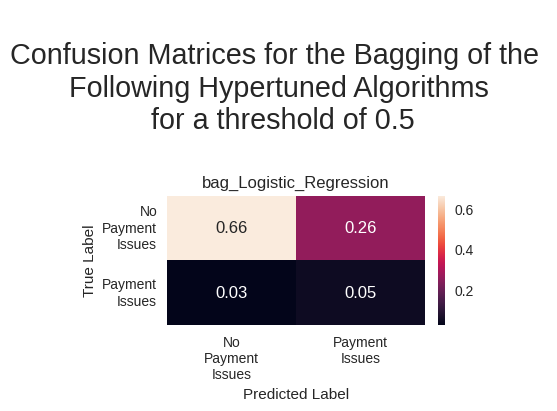

In [ ]:
%%time
%reload_ext autoreload

thresh = 0.5
title = 'for the Bagging of the \n Following Hypertuned Algorithms \
\n for a threshold of '+ str(thresh)

dfunc.plot_confusion_matrices(bag_prob, y_test,
                              names = [bag_name],
                              n_cols = 1, normalize = 'all',
                              threshold = thresh, labels = labels,
                              title = title)

CPU times: user 243 ms, sys: 140 ms, total: 383 ms
Wall time: 264 ms


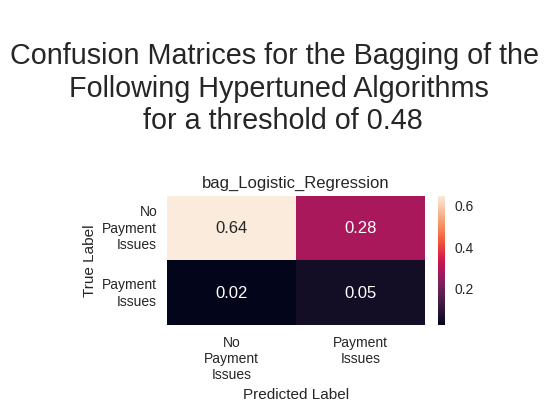

In [ ]:
%%time
%reload_ext autoreload

thresh = 0.48
title = 'for the Bagging of the \n Following Hypertuned Algorithms \
\n for a threshold of '+ str(thresh)

dfunc.plot_confusion_matrices(bag_prob, y_test,
                              names = [bag_name],
                              n_cols = 1, normalize = 'all',
                              threshold = thresh, labels = labels,
                              title = title)

### Bagging LightGBM

In [ ]:
%%time
%reload_ext autoreload

# XGBoost issues with fit_params again...

LGBMClas_bag = LGBMClassifier(class_weight ='balanced', verbosity=-100)
LGBMClas_bag_params = param_classifiers['LightGBM'].copy()
LGBMClas_bag_params.pop('early_stopping_round')
LGBMClas_bag.set_params(**LGBMClas_bag_params)

clf_name = 'LightGBM'
clf = LGBMClas_bag

index = classifiers_h.index(clf_name)
fit_params = fit_params_hyped[index]

bag_name_lgb = 'bag_'+clf_name.replace(' ', '_')
bag_clas = BaggingClassifier(base_estimator=clf,random_state=0,n_estimators=100)

pipe_steps = pipe_prep_steps_tree.copy()    # preprocessor for tree algorithms
pipe_steps.append((bag_name_lgb, bag_clas))
bag_pipe_lgb = Pipeline(pipe_steps)

bag_perf_lgb, bag_results_lgb, bag_prob_lgb = dfunc.model_scores(X_train, y_train, X_test,
                                                     models = [bag_pipe_lgb],
                                                     model_names = [bag_name_lgb],
                                                     cv = cvRSK)


Executing bag_LightGBM
Done!
CPU times: user 11min 55s, sys: 27 s, total: 12min 22s
Wall time: 12min 14s


In [ ]:
bag_perf_lgb.round(3)

,accuracy mean,accuracy std,balanced accuracy mean,balanced accuracy std,f1 mean,f1 std,f1 micro mean,f1 micro std,f1 macro mean,f1 macro std,f1 weighted mean,f1 weighted std,precision mean,precision std,precision micro mean,precision micro std,precision macro mean,precision macro std,precision weighted mean,precision weighted std,average precision mean,average precision std,recall mean,recall std,recall micro mean,recall micro std,recall macro mean,recall macro std,recall weighted mean,recall weighted std,roc auc mean,roc auc std,roc auc ovr mean,roc auc ovr std,roc auc ovo mean,roc auc ovo std,roc auc ovr weighted mean,roc auc ovr weighted std,roc auc ovo weighted mean,roc auc ovo weighted std
bag_LightGBM,0.885,0.015,0.586,0.039,0.235,0.071,0.885,0.015,0.586,0.038,0.885,0.012,0.241,0.076,0.885,0.015,0.589,0.041,0.885,0.011,0.21,0.043,0.233,0.076,0.885,0.015,0.586,0.039,0.885,0.015,0.745,0.035,0.745,0.035,0.745,0.035,0.745,0.035,0.745,0.035


In [ ]:
%reload_ext autoreload

bag_perf_lgb_test = dfunc.get_test_scores_binary(y_test, bag_prob_lgb, model_names = [bag_name_lgb])
bag_perf_lgb_test.round(3)

,balanced accuracy,f1,precision,recall,roc auc
bag_LightGBM,0.584,0.234,0.243,0.225,0.725


##### Confusion Matrix

CPU times: user 255 ms, sys: 139 ms, total: 394 ms
Wall time: 267 ms


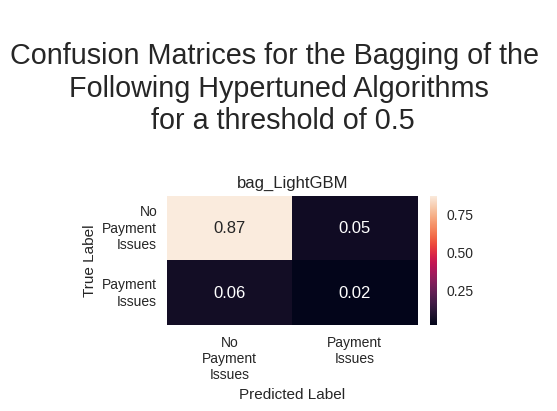

In [ ]:
%%time
%reload_ext autoreload

thresh = 0.5
title = 'for the Bagging of the \n Following Hypertuned Algorithms \
\n for a threshold of '+ str(thresh)

dfunc.plot_confusion_matrices(bag_prob_lgb, y_test,
                              names = [bag_name_lgb],
                              n_cols = 1, normalize = 'all',
                              threshold = thresh, labels = labels,
                              title = title)

CPU times: user 248 ms, sys: 125 ms, total: 374 ms
Wall time: 263 ms


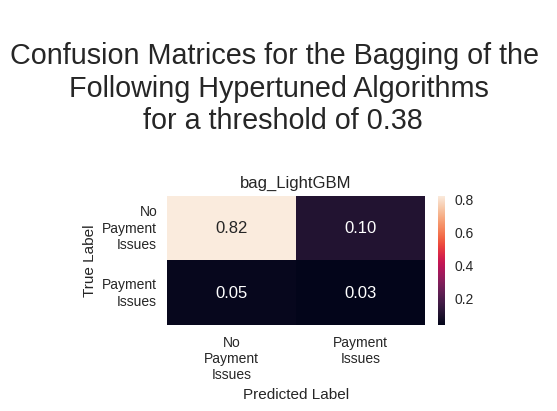

In [ ]:
%%time
%reload_ext autoreload

thresh = 0.38
title = 'for the Bagging of the \n Following Hypertuned Algorithms \
\n for a threshold of '+ str(thresh)

dfunc.plot_confusion_matrices(bag_prob_lgb, y_test,
                              names = [bag_name_lgb],
                              n_cols = 1, normalize = 'all',
                              threshold = thresh, labels = labels,
                              title = title)

## ROCAUC, Precisions-Recall curve and Discrimination Threshold

### ROC AUC

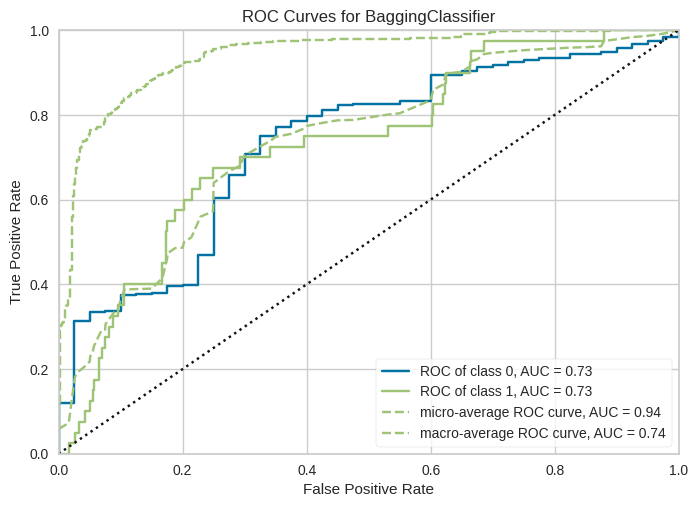

CPU times: user 17.1 s, sys: 683 ms, total: 17.8 s
Wall time: 17.6 s


<Axes: title={'center': 'ROC Curves for BaggingClassifier'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [ ]:
%%time

model_pipe = bag_pipe_lgb
#model_pipe = pipe

model_pipe.fit(X_train, y_train)

visualizer = ROCAUC(model_pipe, classes= LE.classes_)

visualizer.fit(X_train, y_train)        # Fit the training data to the visualizer
visualizer.score(X_test, y_test)        # Evaluate the model on the test data
visualizer.show();

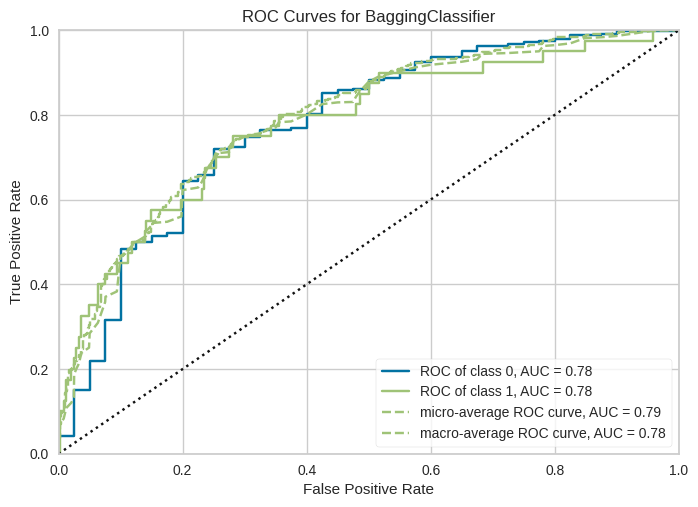

In [ ]:
model_pipe = bag_pipe
#model_pipe = pipe

model_pipe.fit(X_train, y_train)

visualizer = ROCAUC(model_pipe, classes= LE.classes_)

visualizer.fit(X_train, y_train)        # Fit the training data to the visualizer
visualizer.score(X_test, y_test)        # Evaluate the model on the test data
visualizer.show();

### Precision Recall Curve

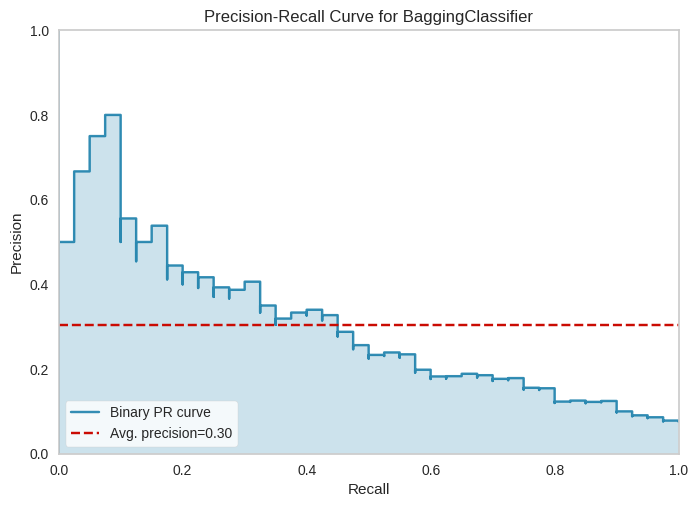

CPU times: user 810 ms, sys: 406 ms, total: 1.22 s
Wall time: 733 ms


<Axes: title={'center': 'Precision-Recall Curve for BaggingClassifier'}, xlabel='Recall', ylabel='Precision'>

In [ ]:
%%time

viz = PrecisionRecallCurve(model_pipe, classes= LE.classes_)
viz.fit(X_train, y_train)
viz.score(X_test, y_test)
viz.show();

### Discrimination Threshold

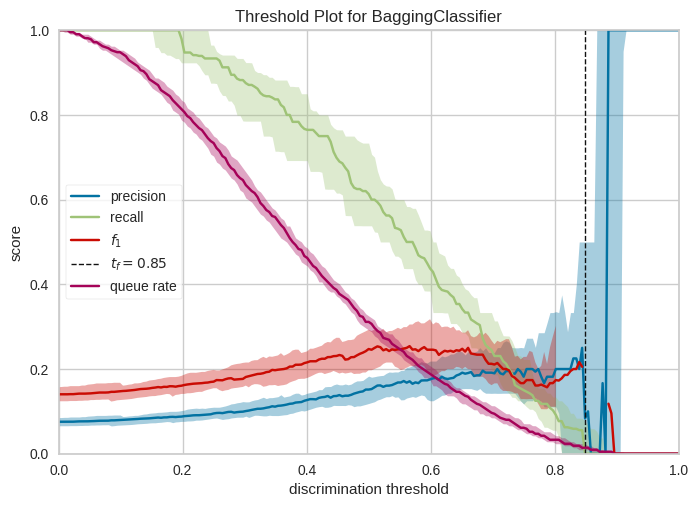

CPU times: user 1min 19s, sys: 16.6 s, total: 1min 36s
Wall time: 2min 53s


<Axes: title={'center': 'Threshold Plot for BaggingClassifier'}, xlabel='discrimination threshold', ylabel='score'>

In [ ]:
%%time
# does not finish for bagged lgb...
# not supported for multiclass
visualizer = DiscriminationThreshold(model_pipe, quantiles=np.array([0.25, 0.5, 0.75]))

visualizer.fit(X_train, y_train)
visualizer.show();

In [ ]:
%%time

# needs results from DiscriminationThreshold - not supported for multiclass

best_threshold = visualizer.thresholds_[visualizer.cv_scores_[visualizer.argmax].argmax()].round(3)
print('best_threshold:', best_threshold.round(3))
thresh_pipe = Thresholder(model_pipe, best_threshold, refit=False)

thresh_pipe.fit(X_train, y_train)

best_threshold: 0.849
CPU times: user 514 µs, sys: 0 ns, total: 514 µs
Wall time: 482 µs


Thresholder(model=Pipeline(steps=[('preprocessor',
                                   ColumnTransformer(remainder='passthrough',
                                                     sparse_threshold=0,
                                                     transformers=[('num',
                                                                    Pipeline(steps=[('imputer',
                                                                                     KNNImputer(n_neighbors=3)),
                                                                                    ('scaler',
                                                                                     StandardScaler())]),
                                                                    ['LIVINGAREA_MODE',
                                                                     'YEARS_BEGINEXPLUATATION_AVG',
                                                                     'NONLIVINGAPARTMENTS_AVG',
                                                                     'ENTRANCES_AVG',
                                                                     'EXT_SOURCE_3',
                                                                     'EXT_SOURCE_2',
                                                                     'EXT_SOURCE_1...
                                                                     'building_avg',
                                                                     'REGION_POPULATION_RELATIVE',
                                                                     'AMT_INCOME_TOTAL']),
                                                                   ('cat',
                                                                    Pipeline(steps=[('encoder',
                                                                                     OneHotEncoder(handle_unknown='ignore'))]),
                                                                    [])])),
                                  ('bag_Logistic_Regression',
                                   BaggingClassifier(base_estimator=LogisticRegression(C=0.02650396190699432,
                                                                                       class_weight='balanced',
                                                                                       n_jobs=-1,
                                                                                       random_state=1),
                                                     n_estimators=100,
                                                     random_state=0))]),
            threshold=0.849)

### Confusion Matrix

CPU times: user 527 ms, sys: 356 ms, total: 883 ms
Wall time: 509 ms


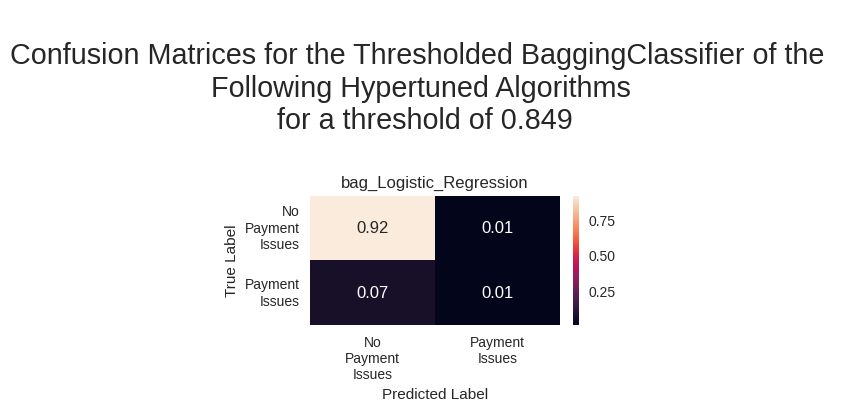

In [ ]:
%%time
%reload_ext autoreload

thresh = 0.51
title = 'for the Thresholded BaggingClassifier of the \n Following Hypertuned Algorithms \
\n for a threshold of '+ str(best_threshold)


thresh_prob = thresh_pipe.predict_proba(X_test)

dfunc.plot_confusion_matrices([thresh_prob], y_test,
                              names = [bag_name],
                              n_cols = 1, normalize = 'all',
                              threshold = best_threshold, labels = labels,
                              title = title)

## Explainability

### Permutation Importance

In [ ]:
%%time

X_test_transformed = pd.DataFrame(bag_pipe[:-1].transform(X_test), columns=new_cols)

perm = PermutationImportance(bag_pipe[-1],
                             n_iter = 5, random_state=1
                             ).fit(X_test_transformed, y_test)
eli5.show_weights(perm, feature_names = new_cols)

CPU times: user 5.4 s, sys: 4.26 s, total: 9.66 s
Wall time: 5.43 s


Weight,Feature
0.0223 ± 0.0229,num__EXT_SOURCE_2
0.0083 ± 0.0081,num__DAYS_BIRTH
0.0057 ± 0.0092,num__ENTRANCES_AVG
0.0049 ± 0.0085,num__LIVINGAPARTMENTS_MODE
0.0049 ± 0.0070,num__LANDAREA_MODE
0.0042 ± 0.0105,num__APARTMENTS_MODE
0.0034 ± 0.0125,num__AMT_ANNUITY_CREDIT_ratio
0.0030 ± 0.0038,num__EXT_RATIO
0.0011 ± 0.0061,num__YEARS_BUILD_MODE
0.0008 ± 0.0051,num__EXT_SUM2


In [ ]:
%%time

X_test_transformed = pd.DataFrame(bag_pipe_lgb[:-1].transform(X_test), columns=new_cols)

perm = PermutationImportance(bag_pipe_lgb[-1],
                             n_iter = 5, random_state=1
                             ).fit(X_test_transformed, y_test)
eli5.show_weights(perm, feature_names = new_cols)

CPU times: user 1min 23s, sys: 1.37 s, total: 1min 24s
Wall time: 1min 25s


Weight,Feature
0.0042 ± 0.0055,num__BASEMENTAREA_MODE
0.0034 ± 0.0146,num__COMMONAREA_MEDI
0.0023 ± 0.0065,num__ENTRANCES_AVG
0.0015 ± 0.0123,num__AMT_ANNUITY_CREDIT_ratio
0.0011 ± 0.0081,num__NONLIVINGAREA_MODE
0.0008 ± 0.0081,num__APARTMENTS_MODE
0.0004 ± 0.0077,num__DAYS_BIRTH
0.0004 ± 0.0087,num__FLOORSMIN_AVG
0.0000 ± 0.0058,num__YEARS_BUILD_MODE
0.0000 ± 0.0041,num__YEARS_BEGINEXPLUATATION_AVG


In [ ]:
%%time
%reload_ext autoreload

clf_name = 'LightGBM'
index = classifiers_h.index(clf_name)
pipe = models_hyped[index]

model_pipe = pipe
model_pipe.fit(X_train, y_train)
X_test_transformed = pd.DataFrame(model_pipe[:-1].transform(X_test), columns=new_cols)

perm = PermutationImportance(model_pipe[-1], scoring=scoring,
                             n_iter = 5, random_state=1
                             ).fit(X_test_transformed, y_test)
eli5.show_weights(perm, feature_names = new_cols)

CPU times: user 1.61 s, sys: 367 ms, total: 1.98 s
Wall time: 1.63 s


Weight,Feature
0.1249 ± 0.0306,num__EXT_SOURCE_2
0.0576 ± 0.0388,num__DAYS_LAST_PHONE_CHANGE
0.0202 ± 0.0452,num__REGION_POPULATION_RELATIVE
0.0154 ± 0.0252,num__AMT_INCOME_TOTAL
0.0152 ± 0.0177,num__EXT_SOURCE_3
0.0140 ± 0.0304,num__EXT_SUM2
0.0116 ± 0.0097,num__APARTMENTS_MODE
0.0104 ± 0.0157,num__DAYS_EMPLOYED
0.0095 ± 0.0099,num__DAYS_REGISTRATION
0.0092 ± 0.0112,num__EXT_SOURCE_1


### SHAP evaluation

#### Bagging Logistic Regression

In [ ]:
%%time

# cannot work on BaggedClassifier as whole - pick one out of the bag

pipe = bag_pipe

model_pipe = pipe
model_pipe.fit(X_train, y_train)

X_test_transformed = np.array(model_pipe[:-1].transform(X_test))
X_train_transformed = np.array(model_pipe[:-1].fit_transform(X_train))

explainer = shap.Explainer(bag_clas[0], X_train_transformed,
                           feature_names=new_cols, )
shap_values = explainer(X_test_transformed) #, check_additivity=False)


CPU times: user 3.56 s, sys: 646 ms, total: 4.21 s
Wall time: 5.38 s


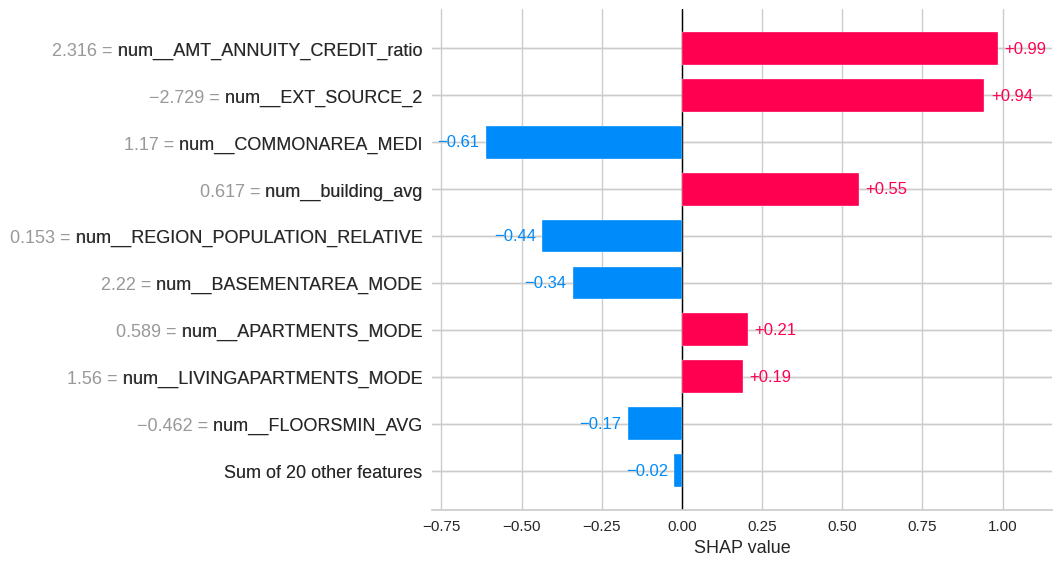

In [ ]:
shap.initjs()
shap.plots.bar(shap_values[0])

#### Logistic Regression

In [ ]:
%%time

clf_name = 'Logistic Regression'
index = classifiers_h.index(clf_name)
pipe = models_hyped[index]

model_pipe = pipe
model_pipe.fit(X_train, y_train)

X_test_transformed = np.array(model_pipe[:-1].transform(X_test))
X_train_transformed = np.array(model_pipe[:-1].fit_transform(X_train))

explainer = shap.Explainer(model_pipe[-1], X_train_transformed,
                           feature_names=new_cols, )
shap_values = explainer(X_test_transformed) #, check_additivity=False)


CPU times: user 1.92 s, sys: 572 ms, total: 2.49 s
Wall time: 1.99 s


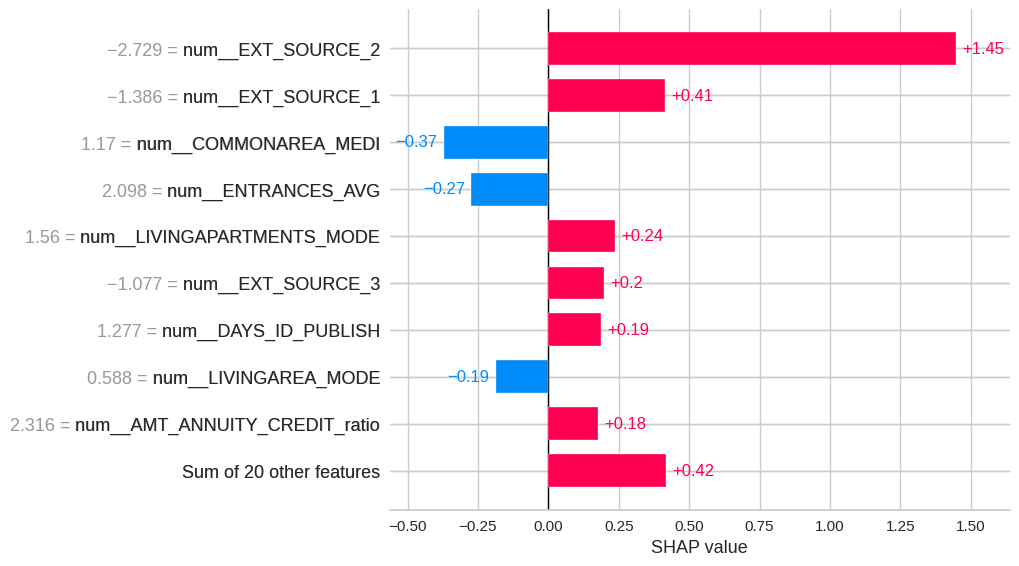

In [ ]:
shap.initjs()
shap.plots.bar(shap_values[0])

#### Bagging LightGBM

In [ ]:
%%time

# does not work for LightGBM, XGBoost (wrappers?), KNN
# drop early stopping parameter (used in .fit())

LGBMClas_shap = LGBMClassifier(class_weight ='balanced', verbosity=-100)
LGBMClas_shap_params = param_classifiers['LightGBM'].copy()
LGBMClas_shap_params.pop('early_stopping_round')
LGBMClas_shap.set_params(**LGBMClas_shap_params)

clf_name = 'LightGBM'
clf = LGBMClas_shap

pipe_steps = pipe_prep_steps_tree.copy()    # preprocessor for tree algorithms
pipe_steps.append((clf_name, clf))
shap_pipe = Pipeline(pipe_steps)

model_pipe = shap_pipe
model_pipe.fit(X_train, y_train)

X_test_transformed = np.array(model_pipe[:-1].transform(X_test))
X_train_transformed = np.array(model_pipe[:-1].fit_transform(X_train))

explainer = shap.Explainer(model_pipe[-1], X_train_transformed,
                           feature_names=new_cols, )
shap_values = explainer(X_test_transformed) #, check_additivity=False)


ExplainerError: Additivity check failed in TreeExplainer! Please ensure the data matrix you passed to the explainer is the same shape that the model was trained on. If your data shape is correct then please report this on GitHub. This check failed because for one of the samples the sum of the SHAP values was -0.691837, while the model output was -0.831394. If this difference is acceptable you can set check_additivity=False to disable this check.

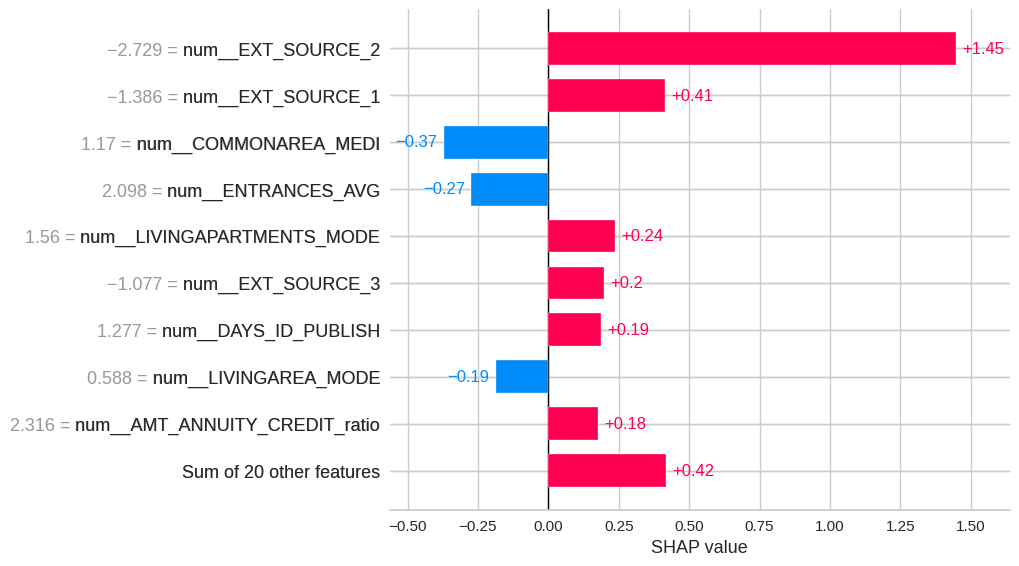

In [ ]:
shap.initjs()
shap.plots.bar(shap_values[0])

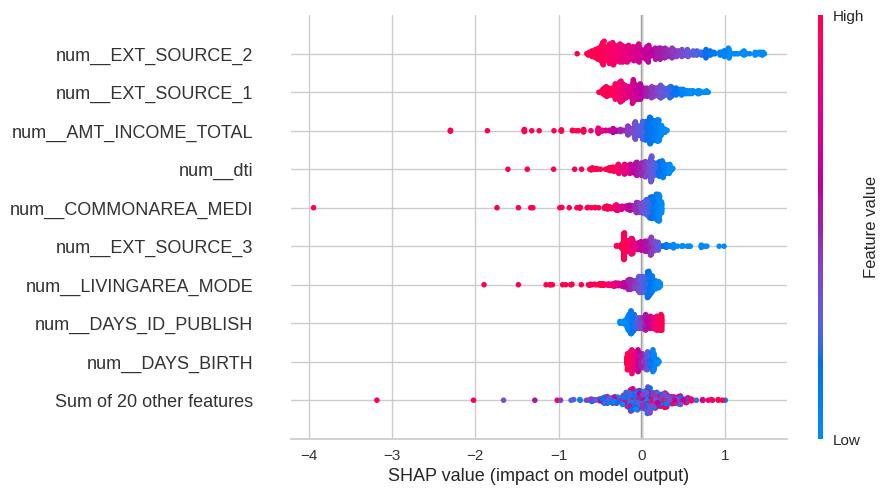

In [ ]:
shap.plots.beeswarm(shap_values)

In [ ]:
shap.initjs()

shap.plots.force(shap_values[1])

In [ ]:
clustering = shap.utils.hclust(X_test_transformed, y_test)

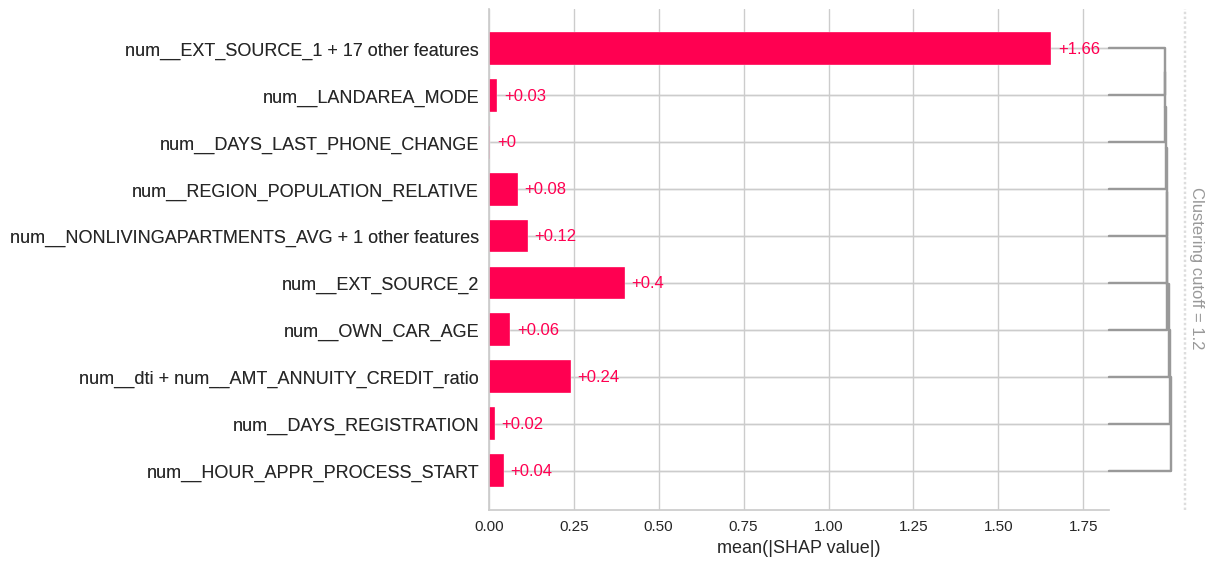

In [ ]:
shap.plots.bar(shap_values, clustering = clustering, clustering_cutoff = 1.2)

### LightGBM Feature Importances

In [ ]:
importance = np.abs(LGBMClas_shap.feature_importances_)

lgb_df = pd.DataFrame(importance,index=new_cols,columns=['Importance'])#.sort_values(by='Rank',ascending=True)
lgb_df.reset_index(inplace=True)
lgb_df = lgb_df.sort_values(by='Importance',ascending=False)

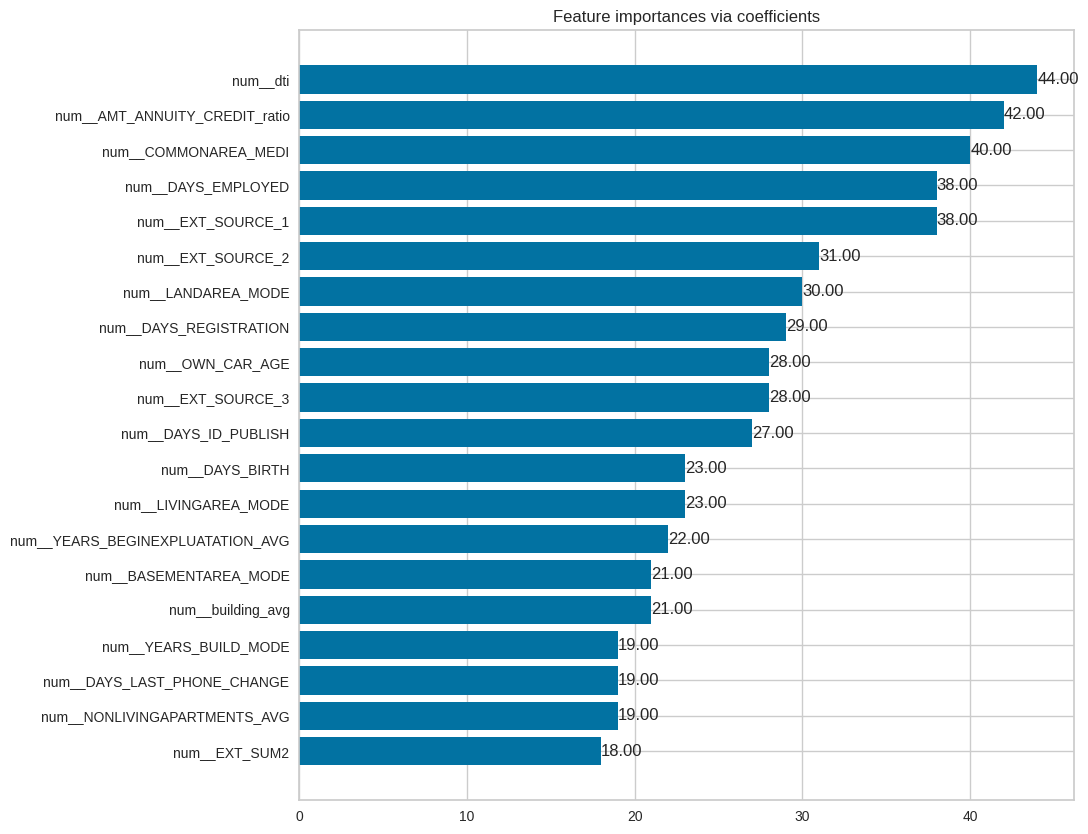

In [ ]:
fig = plt.figure(figsize=(10,10))
ax = fig.gca()  # define axis

limit = min(20, len(lgb_df))

hbars = ax.barh(lgb_df['index'][:limit], lgb_df['Importance'][:limit], align='center')
ax.set_title("Feature importances via coefficients")
ax.invert_yaxis()
ax.bar_label(hbars, fmt='%.2f')
#ax.set_xlim(right=0.107)  # adjust xlim to fit labels

plt.show()

## Final Model

Currently, the API cannot handle LightGBM inside the sklearn routine (missing information in pickle file -> model.predict_proba(X) lead to "'Booster' object has no attribute 'handle'", i.e. it calls lgb-native functions instead of sklearn)

Continue with bagged logistic regression :-(

In [ ]:
final_model = bag_pipe

In [ ]:
final_model.fit(X_train,y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough', sparse_threshold=0,
                                   transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   KNNImputer(n_neighbors=3)),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['LIVINGAREA_MODE',
                                                   'YEARS_BEGINEXPLUATATION_AVG',
                                                   'NONLIVINGAPARTMENTS_AVG',
                                                   'ENTRANCES_AVG',
                                                   'EXT_SOURCE_3',
                                                   'EXT_SOURCE_2',
                                                   'EXT_SOURCE_1',
                                                   'APARTMENTS_MODE...
                                                   'AMT_ANNUITY_CREDIT_ratio',
                                                   'DAYS_BIRTH', 'building_avg',
                                                   'REGION_POPULATION_RELATIVE',
                                                   'AMT_INCOME_TOTAL']),
                                                 ('cat',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  [])])),
                ('bag_Logistic_Regression',
                 BaggingClassifier(base_estimator=LogisticRegression(C=0.02650396190699432,
                                                                     class_weight='balanced',
                                                                     n_jobs=-1,
                                                                     random_state=1),
                                   n_estimators=100, random_state=0))])

In [ ]:
filename = home_folder+'defaultrisk_model_app_only.pickle'
pickle.dump(final_model,open(filename, 'wb'))

In [ ]:
bag_perf_test.round(3)

,balanced accuracy,f1,precision,recall,roc auc
bag_Logistic_Regression,0.684,0.255,0.159,0.65,0.777


In [ ]:
X_test[1:2]

,LIVINGAREA_MODE,YEARS_BEGINEXPLUATATION_AVG,NONLIVINGAPARTMENTS_AVG,ENTRANCES_AVG,EXT_SOURCE_3,EXT_SOURCE_2,EXT_SOURCE_1,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BUILD_MODE,LANDAREA_MODE,HOUR_APPR_PROCESS_START,LIVINGAPARTMENTS_MODE,FLOORSMIN_AVG,NONLIVINGAREA_MODE,DAYS_LAST_PHONE_CHANGE,COMMONAREA_MEDI,EXT_SUM2,dti,OWN_CAR_AGE,EXT_RATIO,DAYS_ID_PUBLISH,DAYS_REGISTRATION,DAYS_EMPLOYED,AMT_ANNUITY_CREDIT_ratio,DAYS_BIRTH,building_avg,REGION_POPULATION_RELATIVE,AMT_INCOME_TOTAL
32036,0.0984,0.9796,0.0,0.069,NaN,0.629409,NaN,0.2111,0.1415,0.7321,0.0452,12,0.1846,0.375,0.0,-27.0,0.0445,NaN,0.286739,NaN,NaN,-4937,-339.0,365243,0.02638,-22521,0.232386,0.030755,103500.0


In [ ]:
final_model.predict_proba(X_test[1:2])

array([[0.72322071, 0.27677929]])

Test Google Cloud deployment:

> curl -X 'POST' \
  'https://payment-issue-appli-only-xrnowswa4a-oe.a.run.app/predict' \
  -H 'accept: application/json' \
  -H 'Content-Type: application/json' \
  -d '{
  "AMT_ANNUITY_CREDIT_ratio": 0.0983,
  "AMT_INCOME_TOTAL": 94500,
  "APARTMENTS_MODE": 0.1229,
  "BASEMENTAREA_MODE": 0.1039,
  "COMMONAREA_MEDI": 0,
  "DAYS_BIRTH": -22529,
  "DAYS_EMPLOYED": 365342,
  "DAYS_ID_PUBLISH": -4185,
  "DAYS_LAST_PHONE_CHANGE": 0.0,
  "DAYS_REGISTRATION": -11083,
  "ENTRANCES_AVG": 0.276,
  "EXT_RATIO": 0,
  "EXT_SOURCE_1": 0,
  "EXT_SOURCE_2": 0.58,
  "EXT_SOURCE_3": 0,
  "EXT_SUM2": 0,
  "FLOORSMIN_AVG": 0,
  "HOUR_APPR_PROCESS_START": 13,
  "LANDAREA_MODE": 0.0579,
  "LIVINGAPARTMENTS_MODE": 0,
  "LIVINGAREA_MODE": 0.1091,
  "NONLIVINGAPARTMENTS_AVG": 0,
  "NONLIVINGAREA_MODE": 0.0948,
  "OWN_CAR_AGE": 0,
  "REGION_POPULATION_RELATIVE": 0.0086,
  "YEARS_BEGINEXPLUATATION_AVG": 0.9806,
  "YEARS_BUILD_MODE": 0,
  "building_avg": 0.2369,
  "dti": 0.1497
}'

In [ ]:
#import onnxruntime as rt
#from skl2onnx import convert_sklearn, update_registered_converter
#from skl2onnx.common.shape_calculator import (
#    calculate_linear_classifier_output_shapes,
#)  # noqa
#from onnxmltools.convert.lightgbm.operator_converters.LightGbm import (
#    convert_lightgbm,
#)  # noqa
#from skl2onnx.common.data_types import FloatTensorType

# Summary

# Improvements

**General**

Feature selection/Cleaning
* software, e.g. Boruta


Models and Optimization
* try other model, e.g. CatBoost

.

**Model-specific**

Logistic Regression
* clip outliers


